In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import tarfile
import cv2
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import time
import matplotlib.patches as patches
from align import AlignDlib
from keras.models import model_from_json
from keras.models import load_model
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score 

In [18]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
ATTRS_NAME = "../data/lfw_attributes.txt"
IMAGES_NAME = "../data/lfw-deepfunneled.tgz"
RAW_IMAGES_NAME = "../data/lfw.tgz"

In [19]:
def decoder(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [20]:
def load_dataset(path):
    img_data_list=[]
    data_path = path

    data_dir_list = os.listdir(data_path)
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
            input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
            #input_img_resize=cv2.resize(input_img,(64,64))
            faces = face_cascade.detectMultiScale(input_img, 1.1, 3)
            print (faces[0])
            #input_img_resize=cv2.resize(input_img,(128,128))
            x,y,w,h = faces[0]
            print(x,y,w,h)
            face = input_img[y:y+h,x:x+w]
            face=cv2.resize(face,(32,32))
            #face=face / 255.0 - 0.5
            #face = np.expand_dims(faces, axis=1)
            img_data_list.append(face)

    img_data = np.stack(img_data_list).astype('uint8')
    #img_data = img_data.astype('float32')
    return img_data/ 255.0 - 0.5

In [21]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    df_attrs.head()
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []


    # Read attrs
    #df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    #df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    #df_attrs.head()
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in f.getmembers():
            # Only process image files from the compressed data
            print(m)
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decoder(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                foldername = os.path.split(m.name)
                filename = os.path.split(m.name)[-1]
                fname_splitted = filename[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'Person': person_id, 'imagenum': photo_number, 'Array': img, "File": filename, "Path": foldername })

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')
    all_photos = all_photos.astype('float32') / 255.0 - 0.5

    # Preserve photo_ids order!
    #all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum'))

    return all_photos, photo_ids#all_attrs

In [22]:
X, photosDf = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

<TarInfo 'lfw' at 0x7f7eba35a1f0>
<TarInfo 'lfw/George_HW_Bush' at 0x7f7eba35a2c0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0001.jpg' at 0x7f7eba35a120>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0002.jpg' at 0x7f7eba35a390>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0003.jpg' at 0x7f7eba35a460>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0004.jpg' at 0x7f7eba35a600>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0005.jpg' at 0x7f7eba35a6d0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0006.jpg' at 0x7f7eba35a7a0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0007.jpg' at 0x7f7eba35a870>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0008.jpg' at 0x7f7eba35a940>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0009.jpg' at 0x7f7eba35aa10>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0010.jpg' at 0x7f7eba35aae0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0011.jpg' at 0x7f7eba35abb0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0012.jpg' at 0x7f7eba35ac80>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bu

<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0023.jpg' at 0x7f7e11706e20>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0024.jpg' at 0x7f7e11706ef0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0025.jpg' at 0x7f7e11706050>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0026.jpg' at 0x7f7e11709120>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0027.jpg' at 0x7f7e117091f0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0028.jpg' at 0x7f7e117092c0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0029.jpg' at 0x7f7e11709390>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0030.jpg' at 0x7f7e11709460>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0031.jpg' at 0x7f7e11709530>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0032.jpg' at 0x7f7e11709600>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0033.jpg' at 0x7f7e117096d0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0034.jpg' at 0x7f7e117097a0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_00

<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0011.jpg' at 0x7f7e117312c0>
<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0012.jpg' at 0x7f7e11731390>
<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0013.jpg' at 0x7f7e11731460>
<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0014.jpg' at 0x7f7e11731530>
<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0015.jpg' at 0x7f7e11731600>
<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0016.jpg' at 0x7f7e117316d0>
<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0017.jpg' at 0x7f7e117317a0>
<TarInfo 'lfw/Pervez_Musharraf/Pervez_Musharraf_0018.jpg' at 0x7f7e11731870>
<TarInfo 'lfw/Robert_Fico' at 0x7f7e11731940>
<TarInfo 'lfw/Robert_Fico/Robert_Fico_0001.jpg' at 0x7f7e11731a10>
<TarInfo 'lfw/Robert_Fico/Robert_Fico_0002.jpg' at 0x7f7e11731050>
<TarInfo 'lfw/JK_Rowling' at 0x7f7e11731bb0>
<TarInfo 'lfw/JK_Rowling/JK_Rowling_0001.jpg' at 0x7f7e11731c80>
<TarInfo 'lfw/JK_Rowling/JK_Rowling_0002.jpg' at 0x7f7e11731ae0>
<TarInfo 'lfw/JK_Rowling/JK_R

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0145.jpg' at 0x7f7e116d76d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0146.jpg' at 0x7f7e116d77a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0147.jpg' at 0x7f7e116d7870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0148.jpg' at 0x7f7e116d7940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0149.jpg' at 0x7f7e116d7a10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0150.jpg' at 0x7f7e116d7ae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0151.jpg' at 0x7f7e116d7bb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0152.jpg' at 0x7f7e116d7c80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0153.jpg' at 0x7f7e116d7d50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0154.jpg' at 0x7f7e116d7e20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0155.jpg' at 0x7f7e116d7ef0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0156.jpg' at 0x7f7e116d7050>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0157.jpg' at 0x7f7e116dc120>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0158.jpg' at 0x7f7e116dc1f0>
<TarIn

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0343.jpg' at 0x7f7e1167fd50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0344.jpg' at 0x7f7e1167fe20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0345.jpg' at 0x7f7e1167fef0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0346.jpg' at 0x7f7e1167f050>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0347.jpg' at 0x7f7e11683120>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0348.jpg' at 0x7f7e116831f0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0349.jpg' at 0x7f7e116832c0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0350.jpg' at 0x7f7e11683390>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0351.jpg' at 0x7f7e11683460>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0352.jpg' at 0x7f7e11683530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0353.jpg' at 0x7f7e11683600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0354.jpg' at 0x7f7e116836d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0355.jpg' at 0x7f7e116837a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0356.jpg' at 0x7f7e11683870>
<TarIn

<TarInfo 'lfw/Ciro_Gomes/Ciro_Gomes_0003.jpg' at 0x7f7e116a5e20>
<TarInfo 'lfw/Ciro_Gomes/Ciro_Gomes_0004.jpg' at 0x7f7e116a5ef0>
<TarInfo 'lfw/Ciro_Gomes/Ciro_Gomes_0005.jpg' at 0x7f7e116a5d50>
<TarInfo 'lfw/Sergio_Garcia' at 0x7f7e116ab050>
<TarInfo 'lfw/Sergio_Garcia/Sergio_Garcia_0001.jpg' at 0x7f7e116ab1f0>
<TarInfo 'lfw/Sergio_Garcia/Sergio_Garcia_0002.jpg' at 0x7f7e116ab120>
<TarInfo 'lfw/Diego_Armando_Maradona' at 0x7f7e116ab390>
<TarInfo 'lfw/Diego_Armando_Maradona/Diego_Armando_Maradona_0001.jpg' at 0x7f7e116ab460>
<TarInfo 'lfw/Hassan_Nasrallah' at 0x7f7e116ab2c0>
<TarInfo 'lfw/Hassan_Nasrallah/Hassan_Nasrallah_0001.jpg' at 0x7f7e116ab600>
<TarInfo 'lfw/Hassan_Nasrallah/Hassan_Nasrallah_0002.jpg' at 0x7f7e116ab530>
<TarInfo 'lfw/Fernando_Vargas' at 0x7f7e116ab7a0>
<TarInfo 'lfw/Fernando_Vargas/Fernando_Vargas_0001.jpg' at 0x7f7e116ab870>
<TarInfo 'lfw/Fernando_Vargas/Fernando_Vargas_0002.jpg' at 0x7f7e116ab6d0>
<TarInfo 'lfw/Fernando_Vargas/Fernando_Vargas_0003.jpg' at 0x7f7

<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0085.jpg' at 0x7f7e11655390>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0086.jpg' at 0x7f7e11655460>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0087.jpg' at 0x7f7e11655530>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0088.jpg' at 0x7f7e11655600>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0089.jpg' at 0x7f7e116556d0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0090.jpg' at 0x7f7e116557a0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0091.jpg' at 0x7f7e11655870>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0092.jpg' at 0x7f7e11655940>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0093.jpg' at 0x7f7e11655a10>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0094.jpg' at 0x7f7e11655ae0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0095.jpg' at 0x7f7e11655bb0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0096.jpg' at 0x7f7e11655c80>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0097.jpg' at 0x7f7e11655d50>
<TarInfo 'lfw/Donald_Rums

<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0010.jpg' at 0x7f7e115ffc80>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0011.jpg' at 0x7f7e115ffd50>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0012.jpg' at 0x7f7e115ffe20>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0013.jpg' at 0x7f7e115ffef0>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0014.jpg' at 0x7f7e115ff600>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0015.jpg' at 0x7f7e11603120>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0016.jpg' at 0x7f7e116031f0>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0017.jpg' at 0x7f7e116032c0>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0018.jpg' at 0x7f7e11603390>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0019.jpg' at 0x7f7e11603460>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0020.jpg' at 0x7f7e11603530>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0021.jpg' at 0x7f7e11603600>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0022.jpg' at 0x7f7e116036d0>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0023.jpg' at 0x7f7e116037a0>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0024.jpg' at 0x7f7e11603

<TarInfo 'lfw/Kjell_Magne_Bondevik/Kjell_Magne_Bondevik_0003.jpg' at 0x7f7e1162f870>
<TarInfo 'lfw/Kofi_Annan' at 0x7f7e1162f940>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0001.jpg' at 0x7f7e1162fa10>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0002.jpg' at 0x7f7e1162f7a0>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0003.jpg' at 0x7f7e1162fbb0>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0004.jpg' at 0x7f7e1162fc80>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0005.jpg' at 0x7f7e1162fd50>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0006.jpg' at 0x7f7e1162fe20>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0007.jpg' at 0x7f7e1162fef0>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0008.jpg' at 0x7f7e1162fae0>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0009.jpg' at 0x7f7e11632120>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0010.jpg' at 0x7f7e116321f0>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0011.jpg' at 0x7f7e116322c0>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0012.jpg' at 0x7f7e11632390>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0013.jpg' at 0x7f7e11632460>
<TarInfo 'lfw/Kofi_Annan/

<TarInfo 'lfw/Tony_Blair/Tony_Blair_0039.jpg' at 0x7f7e115dc530>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0040.jpg' at 0x7f7e115dc600>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0041.jpg' at 0x7f7e115dc6d0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0042.jpg' at 0x7f7e115dc7a0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0043.jpg' at 0x7f7e115dc870>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0044.jpg' at 0x7f7e115dc940>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0045.jpg' at 0x7f7e115dca10>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0046.jpg' at 0x7f7e115dcae0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0047.jpg' at 0x7f7e115dcbb0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0048.jpg' at 0x7f7e115dcc80>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0049.jpg' at 0x7f7e115dcd50>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0050.jpg' at 0x7f7e115dce20>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0051.jpg' at 0x7f7e115dcef0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0052.jpg' at 0x7f7e115dc050>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0053.jpg' at 0x7f7e115e1050>
<TarInfo 'lfw/Tony_Blair/

<TarInfo 'lfw/Reese_Witherspoon/Reese_Witherspoon_0003.jpg' at 0x7f7e1158ac80>
<TarInfo 'lfw/Reese_Witherspoon/Reese_Witherspoon_0004.jpg' at 0x7f7e1158ad50>
<TarInfo 'lfw/Mary_Maddux' at 0x7f7e1158ae20>
<TarInfo 'lfw/Mary_Maddux/Mary_Maddux_0001.jpg' at 0x7f7e1158aef0>
<TarInfo 'lfw/Anthony_Mazur' at 0x7f7e1158abb0>
<TarInfo 'lfw/Anthony_Mazur/Anthony_Mazur_0001.jpg' at 0x7f7e1158d120>
<TarInfo 'lfw/Jon_Corzine' at 0x7f7e1158d050>
<TarInfo 'lfw/Jon_Corzine/Jon_Corzine_0001.jpg' at 0x7f7e1158d2c0>
<TarInfo 'lfw/Jon_Corzine/Jon_Corzine_0002.jpg' at 0x7f7e1158d1f0>
<TarInfo 'lfw/Jon_Corzine/Jon_Corzine_0003.jpg' at 0x7f7e1158d460>
<TarInfo 'lfw/James_McGreevey' at 0x7f7e1158d530>
<TarInfo 'lfw/James_McGreevey/James_McGreevey_0001.jpg' at 0x7f7e1158d600>
<TarInfo 'lfw/James_McGreevey/James_McGreevey_0002.jpg' at 0x7f7e1158d390>
<TarInfo 'lfw/James_McGreevey/James_McGreevey_0003.jpg' at 0x7f7e1158d7a0>
<TarInfo 'lfw/James_McGreevey/James_McGreevey_0004.jpg' at 0x7f7e1158d870>
<TarInfo 'lfw

<TarInfo 'lfw/Colin_Powell/Colin_Powell_0057.jpg' at 0x7f7e115b8c80>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0058.jpg' at 0x7f7e115b8d50>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0059.jpg' at 0x7f7e115b8e20>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0060.jpg' at 0x7f7e115b8ef0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0061.jpg' at 0x7f7e115b8050>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0062.jpg' at 0x7f7e1153c120>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0063.jpg' at 0x7f7e1153c1f0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0064.jpg' at 0x7f7e1153c2c0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0065.jpg' at 0x7f7e1153c390>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0066.jpg' at 0x7f7e1153c460>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0067.jpg' at 0x7f7e1153c530>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0068.jpg' at 0x7f7e1153c600>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0069.jpg' at 0x7f7e1153c6d0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0070.jpg' at 0x7f7e1153c7a0>
<TarInfo 'lfw/Colin_Powell/Colin_P

<TarInfo 'lfw/Laura_Bush/Laura_Bush_0013.jpg' at 0x7f7e11565ef0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0014.jpg' at 0x7f7e11565600>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0015.jpg' at 0x7f7e11568120>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0016.jpg' at 0x7f7e115681f0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0017.jpg' at 0x7f7e115682c0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0018.jpg' at 0x7f7e11568390>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0019.jpg' at 0x7f7e11568460>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0020.jpg' at 0x7f7e11568530>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0021.jpg' at 0x7f7e11568600>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0022.jpg' at 0x7f7e115686d0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0023.jpg' at 0x7f7e115687a0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0024.jpg' at 0x7f7e11568870>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0025.jpg' at 0x7f7e11568940>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0026.jpg' at 0x7f7e11568a10>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0027.jpg' at 0x7f7e11568ae0>
<TarInfo 'lfw/Laura_Bush/

<TarInfo 'lfw/Serena_Williams/Serena_Williams_0022.jpg' at 0x7f7e11518bb0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0023.jpg' at 0x7f7e11518c80>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0024.jpg' at 0x7f7e11518d50>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0025.jpg' at 0x7f7e11518e20>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0026.jpg' at 0x7f7e11518ef0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0027.jpg' at 0x7f7e11518050>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0028.jpg' at 0x7f7e1151b120>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0029.jpg' at 0x7f7e1151b1f0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0030.jpg' at 0x7f7e1151b2c0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0031.jpg' at 0x7f7e1151b390>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0032.jpg' at 0x7f7e1151b460>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0033.jpg' at 0x7f7e1151b530>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0034.jpg' at 0x7f7e1151b600>
<TarInfo 'lfw/Serena_Will

<TarInfo 'lfw/Suh_Young-hoon' at 0x7f7e114caa10>
<TarInfo 'lfw/Suh_Young-hoon/Suh_Young-hoon_0001.jpg' at 0x7f7e114cac80>
<TarInfo 'lfw/Scott_Ritter' at 0x7f7e114cabb0>
<TarInfo 'lfw/Scott_Ritter/Scott_Ritter_0001.jpg' at 0x7f7e114cae20>
<TarInfo 'lfw/Scott_Ritter/Scott_Ritter_0002.jpg' at 0x7f7e114cad50>
<TarInfo 'lfw/Ed_Book' at 0x7f7e114caef0>
<TarInfo 'lfw/Ed_Book/Ed_Book_0001.jpg' at 0x7f7e114cd120>
<TarInfo 'lfw/Robert_Lee_Yates_Jr' at 0x7f7e114cd050>
<TarInfo 'lfw/Robert_Lee_Yates_Jr/Robert_Lee_Yates_Jr_0001.jpg' at 0x7f7e114cd2c0>
<TarInfo 'lfw/Patricia_Phillips' at 0x7f7e114cd1f0>
<TarInfo 'lfw/Patricia_Phillips/Patricia_Phillips_0001.jpg' at 0x7f7e114cd460>
<TarInfo 'lfw/Brian_Williams' at 0x7f7e114cd390>
<TarInfo 'lfw/Brian_Williams/Brian_Williams_0001.jpg' at 0x7f7e114cd600>
<TarInfo 'lfw/Justine_Pasek' at 0x7f7e114cd530>
<TarInfo 'lfw/Justine_Pasek/Justine_Pasek_0001.jpg' at 0x7f7e114cd7a0>
<TarInfo 'lfw/Justine_Pasek/Justine_Pasek_0002.jpg' at 0x7f7e114cd6d0>
<TarInfo 'lf

<TarInfo 'lfw/Nancy_Reagan' at 0x7f7e11482600>
<TarInfo 'lfw/Nancy_Reagan/Nancy_Reagan_0001.jpg' at 0x7f7e114826d0>
<TarInfo 'lfw/Nancy_Reagan/Nancy_Reagan_0002.jpg' at 0x7f7e11482530>
<TarInfo 'lfw/Din_Samsudin' at 0x7f7e11482870>
<TarInfo 'lfw/Din_Samsudin/Din_Samsudin_0001.jpg' at 0x7f7e11482940>
<TarInfo 'lfw/Ellen_DeGeneres' at 0x7f7e114827a0>
<TarInfo 'lfw/Ellen_DeGeneres/Ellen_DeGeneres_0001.jpg' at 0x7f7e11482ae0>
<TarInfo 'lfw/Ellen_DeGeneres/Ellen_DeGeneres_0002.jpg' at 0x7f7e11482a10>
<TarInfo 'lfw/Trevor_Watson' at 0x7f7e11482c80>
<TarInfo 'lfw/Trevor_Watson/Trevor_Watson_0001.jpg' at 0x7f7e11482d50>
<TarInfo 'lfw/Peter_Struck' at 0x7f7e11482bb0>
<TarInfo 'lfw/Peter_Struck/Peter_Struck_0001.jpg' at 0x7f7e11482ef0>
<TarInfo 'lfw/Peter_Struck/Peter_Struck_0002.jpg' at 0x7f7e11482e20>
<TarInfo 'lfw/Peter_Struck/Peter_Struck_0003.jpg' at 0x7f7e11488120>
<TarInfo 'lfw/Peter_Struck/Peter_Struck_0004.jpg' at 0x7f7e114881f0>
<TarInfo 'lfw/Peter_Struck/Peter_Struck_0005.jpg' at 0x7f

<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0009.jpg' at 0x7f7e114b6ef0>
<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0010.jpg' at 0x7f7e114b6940>
<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0011.jpg' at 0x7f7e114ba120>
<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0012.jpg' at 0x7f7e114ba1f0>
<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0013.jpg' at 0x7f7e114ba2c0>
<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0014.jpg' at 0x7f7e114ba390>
<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0015.jpg' at 0x7f7e114ba460>
<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0016.jpg' at 0x7f7e114ba530>
<TarInfo 'lfw/Spencer_Abraham/Spencer_Abraham_0017.jpg' at 0x7f7e114ba600>
<TarInfo 'lfw/Robert_Gordon_Card' at 0x7f7e114ba6d0>
<TarInfo 'lfw/Robert_Gordon_Card/Robert_Gordon_Card_0001.jpg' at 0x7f7e114ba7a0>
<TarInfo 'lfw/Richard_Branson' at 0x7f7e114ba050>
<TarInfo 'lfw/Richard_Branson/Richard_Branson_0001.jpg' at 0x7f7e114ba940>
<TarInfo 'lfw/Richard_Branson/Richard_Branson_0002.jpg' at 0x7f7e1

<TarInfo 'lfw/Elsa_Zylberstein/Elsa_Zylberstein_0005.jpg' at 0x7f7e1146d940>
<TarInfo 'lfw/Elsa_Zylberstein/Elsa_Zylberstein_0006.jpg' at 0x7f7e1146da10>
<TarInfo 'lfw/Anders_Fogh_Rasmussen' at 0x7f7e1146dae0>
<TarInfo 'lfw/Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_0001.jpg' at 0x7f7e1146dbb0>
<TarInfo 'lfw/Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_0002.jpg' at 0x7f7e1146d6d0>
<TarInfo 'lfw/Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_0003.jpg' at 0x7f7e1146dd50>
<TarInfo 'lfw/Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_0004.jpg' at 0x7f7e1146de20>
<TarInfo 'lfw/Gustavo_Kuerten' at 0x7f7e1146def0>
<TarInfo 'lfw/Gustavo_Kuerten/Gustavo_Kuerten_0001.jpg' at 0x7f7e1146dc80>
<TarInfo 'lfw/Gustavo_Kuerten/Gustavo_Kuerten_0002.jpg' at 0x7f7e11473050>
<TarInfo 'lfw/Gustavo_Kuerten/Gustavo_Kuerten_0003.jpg' at 0x7f7e114731f0>
<TarInfo 'lfw/Monica_Seles' at 0x7f7e114732c0>
<TarInfo 'lfw/Monica_Seles/Monica_Seles_0001.jpg' at 0x7f7e11473390>
<TarInfo 'lfw/Monica_Seles/Monica_Seles_0002.jpg' a

<TarInfo 'lfw/John_Kerr' at 0x7f7e1141d600>
<TarInfo 'lfw/John_Kerr/John_Kerr_0001.jpg' at 0x7f7e1141d870>
<TarInfo 'lfw/Hernan_Crespo' at 0x7f7e1141d7a0>
<TarInfo 'lfw/Hernan_Crespo/Hernan_Crespo_0001.jpg' at 0x7f7e1141da10>
<TarInfo 'lfw/Calista_Flockhart' at 0x7f7e1141d940>
<TarInfo 'lfw/Calista_Flockhart/Calista_Flockhart_0001.jpg' at 0x7f7e1141dbb0>
<TarInfo 'lfw/Calista_Flockhart/Calista_Flockhart_0002.jpg' at 0x7f7e1141dae0>
<TarInfo 'lfw/Calista_Flockhart/Calista_Flockhart_0003.jpg' at 0x7f7e1141dd50>
<TarInfo 'lfw/Calista_Flockhart/Calista_Flockhart_0004.jpg' at 0x7f7e1141de20>
<TarInfo 'lfw/Calista_Flockhart/Calista_Flockhart_0005.jpg' at 0x7f7e1141def0>
<TarInfo 'lfw/Calista_Flockhart/Calista_Flockhart_0006.jpg' at 0x7f7e1141dc80>
<TarInfo 'lfw/Yao_Ming' at 0x7f7e11422120>
<TarInfo 'lfw/Yao_Ming/Yao_Ming_0001.jpg' at 0x7f7e114221f0>
<TarInfo 'lfw/Yao_Ming/Yao_Ming_0002.jpg' at 0x7f7e11422050>
<TarInfo 'lfw/Yao_Ming/Yao_Ming_0003.jpg' at 0x7f7e11422390>
<TarInfo 'lfw/Yao_Ming

<TarInfo 'lfw/Carla_Myers/Carla_Myers_0002.jpg' at 0x7f7e113d17a0>
<TarInfo 'lfw/Jerry_Lewis' at 0x7f7e113d1ae0>
<TarInfo 'lfw/Jerry_Lewis/Jerry_Lewis_0001.jpg' at 0x7f7e113d1bb0>
<TarInfo 'lfw/Hu_Jintao' at 0x7f7e113d1a10>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0001.jpg' at 0x7f7e113d1d50>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0002.jpg' at 0x7f7e113d1c80>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0003.jpg' at 0x7f7e113d1ef0>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0004.jpg' at 0x7f7e113d1e20>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0005.jpg' at 0x7f7e113d5120>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0006.jpg' at 0x7f7e113d51f0>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0007.jpg' at 0x7f7e113d52c0>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0008.jpg' at 0x7f7e113d5390>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0009.jpg' at 0x7f7e113d5460>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0010.jpg' at 0x7f7e113d5530>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0011.jpg' at 0x7f7e113d5600>
<TarInfo 'lfw/Hu_Jintao/Hu_Jintao_0012.jpg' at 0x7f7e113d56d0>
<TarInfo 'lfw/Hu_Jin

<TarInfo 'lfw/Michael_Patrick_King' at 0x7f7e11384460>
<TarInfo 'lfw/Michael_Patrick_King/Michael_Patrick_King_0001.jpg' at 0x7f7e11384530>
<TarInfo 'lfw/Michael_Patrick_King/Michael_Patrick_King_0002.jpg' at 0x7f7e11384390>
<TarInfo 'lfw/Jay_Leno' at 0x7f7e113846d0>
<TarInfo 'lfw/Jay_Leno/Jay_Leno_0001.jpg' at 0x7f7e113847a0>
<TarInfo 'lfw/Jay_Leno/Jay_Leno_0002.jpg' at 0x7f7e11384600>
<TarInfo 'lfw/Jay_Leno/Jay_Leno_0003.jpg' at 0x7f7e11384940>
<TarInfo 'lfw/Brad_Garrett' at 0x7f7e11384a10>
<TarInfo 'lfw/Brad_Garrett/Brad_Garrett_0001.jpg' at 0x7f7e11384ae0>
<TarInfo 'lfw/Brad_Garrett/Brad_Garrett_0002.jpg' at 0x7f7e11384870>
<TarInfo 'lfw/Brad_Garrett/Brad_Garrett_0003.jpg' at 0x7f7e11384c80>
<TarInfo 'lfw/Brad_Garrett/Brad_Garrett_0004.jpg' at 0x7f7e11384d50>
<TarInfo 'lfw/Alan_Ball' at 0x7f7e11384e20>
<TarInfo 'lfw/Alan_Ball/Alan_Ball_0001.jpg' at 0x7f7e11384ef0>
<TarInfo 'lfw/Alan_Ball/Alan_Ball_0002.jpg' at 0x7f7e11384bb0>
<TarInfo 'lfw/Alec_Baldwin' at 0x7f7e11389120>
<TarInfo 

<TarInfo 'lfw/Wan_Yanhai' at 0x7f7e11340600>
<TarInfo 'lfw/Wan_Yanhai/Wan_Yanhai_0001.jpg' at 0x7f7e11340d50>
<TarInfo 'lfw/Nicole_Kidman' at 0x7f7e11340c80>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0001.jpg' at 0x7f7e11340ef0>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0002.jpg' at 0x7f7e11340e20>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0003.jpg' at 0x7f7e11344120>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0004.jpg' at 0x7f7e113441f0>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0005.jpg' at 0x7f7e113442c0>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0006.jpg' at 0x7f7e11344390>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0007.jpg' at 0x7f7e11344460>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0008.jpg' at 0x7f7e11344530>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0009.jpg' at 0x7f7e11344600>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0010.jpg' at 0x7f7e113446d0>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0011.jpg' at 0x7f7e113447a0>
<TarInfo 'lfw/Nicole_Kidman/Nicole_Kidman_0012.jpg' at 0x7f7e

<TarInfo 'lfw/Rod_Paige' at 0x7f7e11376600>
<TarInfo 'lfw/Rod_Paige/Rod_Paige_0001.jpg' at 0x7f7e11376870>
<TarInfo 'lfw/Gian_Marco' at 0x7f7e113767a0>
<TarInfo 'lfw/Gian_Marco/Gian_Marco_0001.jpg' at 0x7f7e11376a10>
<TarInfo 'lfw/Gian_Marco/Gian_Marco_0002.jpg' at 0x7f7e11376940>
<TarInfo 'lfw/Gian_Marco/Gian_Marco_0003.jpg' at 0x7f7e11376bb0>
<TarInfo 'lfw/Jean_Nagel' at 0x7f7e11376c80>
<TarInfo 'lfw/Jean_Nagel/Jean_Nagel_0001.jpg' at 0x7f7e11376d50>
<TarInfo 'lfw/Al_Gore' at 0x7f7e11376ae0>
<TarInfo 'lfw/Al_Gore/Al_Gore_0001.jpg' at 0x7f7e11376ef0>
<TarInfo 'lfw/Al_Gore/Al_Gore_0002.jpg' at 0x7f7e11376e20>
<TarInfo 'lfw/Al_Gore/Al_Gore_0003.jpg' at 0x7f7e112fc120>
<TarInfo 'lfw/Al_Gore/Al_Gore_0004.jpg' at 0x7f7e112fc1f0>
<TarInfo 'lfw/Al_Gore/Al_Gore_0005.jpg' at 0x7f7e112fc2c0>
<TarInfo 'lfw/Al_Gore/Al_Gore_0006.jpg' at 0x7f7e112fc390>
<TarInfo 'lfw/Al_Gore/Al_Gore_0007.jpg' at 0x7f7e112fc460>
<TarInfo 'lfw/Al_Gore/Al_Gore_0008.jpg' at 0x7f7e112fc050>
<TarInfo 'lfw/James_Franco' a

<TarInfo 'lfw/Boris_Trajkovski' at 0x7f7e1132ea10>
<TarInfo 'lfw/Boris_Trajkovski/Boris_Trajkovski_0001.jpg' at 0x7f7e1132ec80>
<TarInfo 'lfw/Branko_Crvenkovski' at 0x7f7e1132ebb0>
<TarInfo 'lfw/Branko_Crvenkovski/Branko_Crvenkovski_0001.jpg' at 0x7f7e1132ee20>
<TarInfo 'lfw/Branko_Crvenkovski/Branko_Crvenkovski_0002.jpg' at 0x7f7e1132ed50>
<TarInfo 'lfw/Branko_Crvenkovski/Branko_Crvenkovski_0003.jpg' at 0x7f7e1132eef0>
<TarInfo 'lfw/Jose_Acasuso' at 0x7f7e11332120>
<TarInfo 'lfw/Jose_Acasuso/Jose_Acasuso_0001.jpg' at 0x7f7e113321f0>
<TarInfo 'lfw/Andy_Perez' at 0x7f7e11332050>
<TarInfo 'lfw/Andy_Perez/Andy_Perez_0001.jpg' at 0x7f7e11332390>
<TarInfo 'lfw/Patricia_Clarkson' at 0x7f7e113322c0>
<TarInfo 'lfw/Patricia_Clarkson/Patricia_Clarkson_0001.jpg' at 0x7f7e11332530>
<TarInfo 'lfw/Patricia_Clarkson/Patricia_Clarkson_0002.jpg' at 0x7f7e11332460>
<TarInfo 'lfw/Patricia_Clarkson/Patricia_Clarkson_0003.jpg' at 0x7f7e113326d0>
<TarInfo 'lfw/Patricia_Clarkson/Patricia_Clarkson_0004.jpg' a

<TarInfo 'lfw/Nanni_Moretti' at 0x7f7e112ee1f0>
<TarInfo 'lfw/Nanni_Moretti/Nanni_Moretti_0001.jpg' at 0x7f7e112ee870>
<TarInfo 'lfw/Nanni_Moretti/Nanni_Moretti_0002.jpg' at 0x7f7e112ee7a0>
<TarInfo 'lfw/Stefan_Holm' at 0x7f7e112eea10>
<TarInfo 'lfw/Stefan_Holm/Stefan_Holm_0001.jpg' at 0x7f7e112eeae0>
<TarInfo 'lfw/Mark_Mulder' at 0x7f7e112ee940>
<TarInfo 'lfw/Mark_Mulder/Mark_Mulder_0001.jpg' at 0x7f7e112eec80>
<TarInfo 'lfw/Colin_Campbell' at 0x7f7e112eebb0>
<TarInfo 'lfw/Colin_Campbell/Colin_Campbell_0001.jpg' at 0x7f7e112eee20>
<TarInfo 'lfw/Steve_Shiver' at 0x7f7e112eed50>
<TarInfo 'lfw/Steve_Shiver/Steve_Shiver_0001.jpg' at 0x7f7e112eeef0>
<TarInfo 'lfw/Alex_Penelas' at 0x7f7e112f2050>
<TarInfo 'lfw/Alex_Penelas/Alex_Penelas_0001.jpg' at 0x7f7e112f21f0>
<TarInfo 'lfw/Alex_Penelas/Alex_Penelas_0002.jpg' at 0x7f7e112f2120>
<TarInfo 'lfw/Wolfgang_Schuessel' at 0x7f7e112f2390>
<TarInfo 'lfw/Wolfgang_Schuessel/Wolfgang_Schuessel_0001.jpg' at 0x7f7e112f2460>
<TarInfo 'lfw/Wolfgang_Schu

<TarInfo 'lfw/Chris_Dodd' at 0x7f7e112a9ef0>
<TarInfo 'lfw/Chris_Dodd/Chris_Dodd_0001.jpg' at 0x7f7e112a9bb0>
<TarInfo 'lfw/Aicha_El_Ouafi' at 0x7f7e112ae050>
<TarInfo 'lfw/Aicha_El_Ouafi/Aicha_El_Ouafi_0001.jpg' at 0x7f7e112ae1f0>
<TarInfo 'lfw/Aicha_El_Ouafi/Aicha_El_Ouafi_0002.jpg' at 0x7f7e112ae120>
<TarInfo 'lfw/Aicha_El_Ouafi/Aicha_El_Ouafi_0003.jpg' at 0x7f7e112ae390>
<TarInfo 'lfw/Cathy_Freeman' at 0x7f7e112ae460>
<TarInfo 'lfw/Cathy_Freeman/Cathy_Freeman_0001.jpg' at 0x7f7e112ae530>
<TarInfo 'lfw/Cathy_Freeman/Cathy_Freeman_0002.jpg' at 0x7f7e112ae2c0>
<TarInfo 'lfw/Juan_Antonio_Samaranch' at 0x7f7e112ae6d0>
<TarInfo 'lfw/Juan_Antonio_Samaranch/Juan_Antonio_Samaranch_0001.jpg' at 0x7f7e112ae7a0>
<TarInfo 'lfw/Drew_Bledsoe' at 0x7f7e112ae600>
<TarInfo 'lfw/Drew_Bledsoe/Drew_Bledsoe_0001.jpg' at 0x7f7e112ae940>
<TarInfo 'lfw/Dick_Clark' at 0x7f7e112ae870>
<TarInfo 'lfw/Dick_Clark/Dick_Clark_0001.jpg' at 0x7f7e112aeae0>
<TarInfo 'lfw/Dick_Clark/Dick_Clark_0002.jpg' at 0x7f7e112ae

<TarInfo 'lfw/Mark_Redman' at 0x7f7e11265120>
<TarInfo 'lfw/Mark_Redman/Mark_Redman_0001.jpg' at 0x7f7e11265460>
<TarInfo 'lfw/Helen_Clark' at 0x7f7e11265390>
<TarInfo 'lfw/Helen_Clark/Helen_Clark_0001.jpg' at 0x7f7e11265600>
<TarInfo 'lfw/Helen_Clark/Helen_Clark_0002.jpg' at 0x7f7e11265530>
<TarInfo 'lfw/Helen_Clark/Helen_Clark_0003.jpg' at 0x7f7e112657a0>
<TarInfo 'lfw/Helen_Clark/Helen_Clark_0004.jpg' at 0x7f7e11265870>
<TarInfo 'lfw/Bryan_Thomas' at 0x7f7e11265940>
<TarInfo 'lfw/Bryan_Thomas/Bryan_Thomas_0001.jpg' at 0x7f7e11265a10>
<TarInfo 'lfw/Michael_Sullivan' at 0x7f7e112656d0>
<TarInfo 'lfw/Michael_Sullivan/Michael_Sullivan_0001.jpg' at 0x7f7e11265bb0>
<TarInfo 'lfw/Michael_Sullivan/Michael_Sullivan_0002.jpg' at 0x7f7e11265ae0>
<TarInfo 'lfw/Hassanal_Bolkiah' at 0x7f7e11265d50>
<TarInfo 'lfw/Hassanal_Bolkiah/Hassanal_Bolkiah_0001.jpg' at 0x7f7e11265e20>
<TarInfo 'lfw/Tom_Foy' at 0x7f7e11265c80>
<TarInfo 'lfw/Tom_Foy/Tom_Foy_0001.jpg' at 0x7f7e11265ef0>
<TarInfo 'lfw/Marilyn_M

<TarInfo 'lfw/Carlos_Ruckauf' at 0x7f7e11217ef0>
<TarInfo 'lfw/Carlos_Ruckauf/Carlos_Ruckauf_0001.jpg' at 0x7f7e11217e20>
<TarInfo 'lfw/Britney_Spears' at 0x7f7e1121c050>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0001.jpg' at 0x7f7e1121c1f0>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0002.jpg' at 0x7f7e1121c120>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0003.jpg' at 0x7f7e1121c390>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0004.jpg' at 0x7f7e1121c460>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0005.jpg' at 0x7f7e1121c530>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0006.jpg' at 0x7f7e1121c600>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0007.jpg' at 0x7f7e1121c6d0>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0008.jpg' at 0x7f7e1121c7a0>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0009.jpg' at 0x7f7e1121c870>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0010.jpg' at 0x7f7e1121c940>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0011.jpg' at 0x7f7e1121ca10>
<TarInfo 'lfw/Britney_Spea

<TarInfo 'lfw/Zico' at 0x7f7e111ceae0>
<TarInfo 'lfw/Zico/Zico_0001.jpg' at 0x7f7e111cebb0>
<TarInfo 'lfw/Zico/Zico_0002.jpg' at 0x7f7e111cea10>
<TarInfo 'lfw/Zico/Zico_0003.jpg' at 0x7f7e111ced50>
<TarInfo 'lfw/Robin_McGraw' at 0x7f7e111cee20>
<TarInfo 'lfw/Robin_McGraw/Robin_McGraw_0001.jpg' at 0x7f7e111ceef0>
<TarInfo 'lfw/Saburo_Kawabuchi' at 0x7f7e111cec80>
<TarInfo 'lfw/Saburo_Kawabuchi/Saburo_Kawabuchi_0001.jpg' at 0x7f7e111d3120>
<TarInfo 'lfw/Saburo_Kawabuchi/Saburo_Kawabuchi_0002.jpg' at 0x7f7e111d3050>
<TarInfo 'lfw/John_Sidgmore' at 0x7f7e111d32c0>
<TarInfo 'lfw/John_Sidgmore/John_Sidgmore_0001.jpg' at 0x7f7e111d3390>
<TarInfo 'lfw/Chang_Saio-yue' at 0x7f7e111d31f0>
<TarInfo 'lfw/Chang_Saio-yue/Chang_Saio-yue_0001.jpg' at 0x7f7e111d3530>
<TarInfo 'lfw/Gary_Paer' at 0x7f7e111d3460>
<TarInfo 'lfw/Gary_Paer/Gary_Paer_0001.jpg' at 0x7f7e111d36d0>
<TarInfo 'lfw/Cyndi_Thompson' at 0x7f7e111d3600>
<TarInfo 'lfw/Cyndi_Thompson/Cyndi_Thompson_0001.jpg' at 0x7f7e111d3870>
<TarInfo 'l

<TarInfo 'lfw/Rod_Blagojevich' at 0x7f7e1118b050>
<TarInfo 'lfw/Rod_Blagojevich/Rod_Blagojevich_0001.jpg' at 0x7f7e1118b1f0>
<TarInfo 'lfw/Rod_Blagojevich/Rod_Blagojevich_0002.jpg' at 0x7f7e1118b120>
<TarInfo 'lfw/Patti_Balgojevich' at 0x7f7e1118b390>
<TarInfo 'lfw/Patti_Balgojevich/Patti_Balgojevich_0001.jpg' at 0x7f7e1118b460>
<TarInfo 'lfw/Kathryn_Grayson' at 0x7f7e1118b2c0>
<TarInfo 'lfw/Kathryn_Grayson/Kathryn_Grayson_0001.jpg' at 0x7f7e1118b600>
<TarInfo 'lfw/Salman_Rushdie' at 0x7f7e1118b530>
<TarInfo 'lfw/Salman_Rushdie/Salman_Rushdie_0001.jpg' at 0x7f7e1118b7a0>
<TarInfo 'lfw/Salman_Rushdie/Salman_Rushdie_0002.jpg' at 0x7f7e1118b6d0>
<TarInfo 'lfw/Salman_Rushdie/Salman_Rushdie_0003.jpg' at 0x7f7e1118b940>
<TarInfo 'lfw/Judith_Nathan' at 0x7f7e1118ba10>
<TarInfo 'lfw/Judith_Nathan/Judith_Nathan_0001.jpg' at 0x7f7e1118bae0>
<TarInfo 'lfw/James_Cunningham' at 0x7f7e1118b870>
<TarInfo 'lfw/James_Cunningham/James_Cunningham_0001.jpg' at 0x7f7e1118bc80>
<TarInfo 'lfw/James_Cunningha

<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0020.jpg' at 0x7f7e111b7d50>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0021.jpg' at 0x7f7e111b7e20>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0022.jpg' at 0x7f7e111b7ef0>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0023.jpg' at 0x7f7e111b7120>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0024.jpg' at 0x7f7e111ba120>
<TarInfo 'lfw/Angie_Martinez' at 0x7f7e111ba1f0>
<TarInfo 'lfw/Angie_Martinez/Angie_Martinez_0001.jpg' at 0x7f7e111ba2c0>
<TarInfo 'lfw/Carlos_Menem' at 0x7f7e111ba050>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0001.jpg' at 0x7f7e111ba460>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0002.jpg' at 0x7f7e111ba390>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0003.jpg' at 0x7f7e111ba600>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0004.jpg' at 0x7f7e111ba6d0>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0005.jpg' at 0x7f7e111ba7a0>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0006.jpg' at 0x7f7e111ba870>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0007.jpg' at 0x7f7e111ba940>
<Ta

<TarInfo 'lfw/Omar_el-Heib' at 0x7f7e11162ae0>
<TarInfo 'lfw/Omar_el-Heib/Omar_el-Heib_0001.jpg' at 0x7f7e11162e20>
<TarInfo 'lfw/Nawabzada_Nasrullah_Khan' at 0x7f7e11162d50>
<TarInfo 'lfw/Nawabzada_Nasrullah_Khan/Nawabzada_Nasrullah_Khan_0001.jpg' at 0x7f7e11162ef0>
<TarInfo 'lfw/Andrea_Bocelli' at 0x7f7e11165050>
<TarInfo 'lfw/Andrea_Bocelli/Andrea_Bocelli_0001.jpg' at 0x7f7e11165120>
<TarInfo 'lfw/John_Rusnak' at 0x7f7e111651f0>
<TarInfo 'lfw/John_Rusnak/John_Rusnak_0001.jpg' at 0x7f7e11165390>
<TarInfo 'lfw/Adisai_Bodharamik' at 0x7f7e111652c0>
<TarInfo 'lfw/Adisai_Bodharamik/Adisai_Bodharamik_0001.jpg' at 0x7f7e11165530>
<TarInfo 'lfw/Sung_Hong_Choi' at 0x7f7e11165460>
<TarInfo 'lfw/Sung_Hong_Choi/Sung_Hong_Choi_0001.jpg' at 0x7f7e111656d0>
<TarInfo 'lfw/Jean-Claude_Juncker' at 0x7f7e11165600>
<TarInfo 'lfw/Jean-Claude_Juncker/Jean-Claude_Juncker_0001.jpg' at 0x7f7e11165870>
<TarInfo 'lfw/Jean-Claude_Juncker/Jean-Claude_Juncker_0002.jpg' at 0x7f7e111657a0>
<TarInfo 'lfw/Jim_Wall' 

<TarInfo 'lfw/Carlos_Moya/Carlos_Moya_0017.jpg' at 0x7f7e1110a2c0>
<TarInfo 'lfw/Carlos_Moya/Carlos_Moya_0018.jpg' at 0x7f7e1110a390>
<TarInfo 'lfw/Carlos_Moya/Carlos_Moya_0019.jpg' at 0x7f7e1110a460>
<TarInfo 'lfw/Arnold_Schwarzenegger' at 0x7f7e1110a530>
<TarInfo 'lfw/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0001.jpg' at 0x7f7e1110a600>
<TarInfo 'lfw/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0002.jpg' at 0x7f7e1110a050>
<TarInfo 'lfw/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0003.jpg' at 0x7f7e1110a7a0>
<TarInfo 'lfw/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0004.jpg' at 0x7f7e1110a870>
<TarInfo 'lfw/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0005.jpg' at 0x7f7e1110a940>
<TarInfo 'lfw/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0006.jpg' at 0x7f7e1110aa10>
<TarInfo 'lfw/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0007.jpg' at 0x7f7e1110aae0>
<TarInfo 'lfw/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0008.jpg' at 0x7f7e1110abb0>
<TarInfo 'lfw/Arnold_Schwarzenegger/Arnold_Schw

<TarInfo 'lfw/Alan_Trammell' at 0x7f7e110bb530>
<TarInfo 'lfw/Alan_Trammell/Alan_Trammell_0001.jpg' at 0x7f7e110bb7a0>
<TarInfo 'lfw/Vincent_Spadea' at 0x7f7e110bb6d0>
<TarInfo 'lfw/Vincent_Spadea/Vincent_Spadea_0001.jpg' at 0x7f7e110bb940>
<TarInfo 'lfw/Robin_Williams' at 0x7f7e110bb870>
<TarInfo 'lfw/Robin_Williams/Robin_Williams_0001.jpg' at 0x7f7e110bbae0>
<TarInfo 'lfw/Basdeo_Panday' at 0x7f7e110bba10>
<TarInfo 'lfw/Basdeo_Panday/Basdeo_Panday_0001.jpg' at 0x7f7e110bbc80>
<TarInfo 'lfw/Koichi_Tanaka' at 0x7f7e110bbbb0>
<TarInfo 'lfw/Koichi_Tanaka/Koichi_Tanaka_0001.jpg' at 0x7f7e110bbe20>
<TarInfo 'lfw/Tristan_Gretzky' at 0x7f7e110bbd50>
<TarInfo 'lfw/Tristan_Gretzky/Tristan_Gretzky_0001.jpg' at 0x7f7e110bbef0>
<TarInfo 'lfw/Nikki_Cascone' at 0x7f7e110bf050>
<TarInfo 'lfw/Nikki_Cascone/Nikki_Cascone_0001.jpg' at 0x7f7e110bf1f0>
<TarInfo 'lfw/Raag_Singhal' at 0x7f7e110bf120>
<TarInfo 'lfw/Raag_Singhal/Raag_Singhal_0001.jpg' at 0x7f7e110bf390>
<TarInfo 'lfw/Shane_Warne' at 0x7f7e110

<TarInfo 'lfw/Walter_Mondale/Walter_Mondale_0009.jpg' at 0x7f7e110f6530>
<TarInfo 'lfw/Walter_Mondale/Walter_Mondale_0010.jpg' at 0x7f7e110f6600>
<TarInfo 'lfw/Emma_Watson' at 0x7f7e110f66d0>
<TarInfo 'lfw/Emma_Watson/Emma_Watson_0001.jpg' at 0x7f7e110f67a0>
<TarInfo 'lfw/Emma_Watson/Emma_Watson_0002.jpg' at 0x7f7e110f6050>
<TarInfo 'lfw/Emma_Watson/Emma_Watson_0003.jpg' at 0x7f7e110f6940>
<TarInfo 'lfw/Emma_Watson/Emma_Watson_0004.jpg' at 0x7f7e110f6a10>
<TarInfo 'lfw/Emma_Watson/Emma_Watson_0005.jpg' at 0x7f7e110f6ae0>
<TarInfo 'lfw/William_Webster' at 0x7f7e110f6bb0>
<TarInfo 'lfw/William_Webster/William_Webster_0001.jpg' at 0x7f7e110f6c80>
<TarInfo 'lfw/Pak_Gil_Yon' at 0x7f7e110f6870>
<TarInfo 'lfw/Pak_Gil_Yon/Pak_Gil_Yon_0001.jpg' at 0x7f7e110f6e20>
<TarInfo 'lfw/Michael_Kirby' at 0x7f7e110f6d50>
<TarInfo 'lfw/Michael_Kirby/Michael_Kirby_0001.jpg' at 0x7f7e110f6ef0>
<TarInfo 'lfw/Heizo_Takenaka' at 0x7f7e110f9050>
<TarInfo 'lfw/Heizo_Takenaka/Heizo_Takenaka_0001.jpg' at 0x7f7e110f

<TarInfo 'lfw/Cameron_Diaz' at 0x7f7e110b1460>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0001.jpg' at 0x7f7e110b16d0>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0002.jpg' at 0x7f7e110b1600>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0003.jpg' at 0x7f7e110b1870>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0004.jpg' at 0x7f7e110b1940>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0005.jpg' at 0x7f7e110b1a10>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0006.jpg' at 0x7f7e110b1ae0>
<TarInfo 'lfw/Jodie_Foster' at 0x7f7e110b1bb0>
<TarInfo 'lfw/Jodie_Foster/Jodie_Foster_0001.jpg' at 0x7f7e110b1c80>
<TarInfo 'lfw/Jodie_Foster/Jodie_Foster_0002.jpg' at 0x7f7e110b17a0>
<TarInfo 'lfw/Jodie_Foster/Jodie_Foster_0003.jpg' at 0x7f7e110b1e20>
<TarInfo 'lfw/Peter_Rasch' at 0x7f7e110b1ef0>
<TarInfo 'lfw/Peter_Rasch/Peter_Rasch_0001.jpg' at 0x7f7e110b1d50>
<TarInfo 'lfw/Rainer_Geulen' at 0x7f7e110b6050>
<TarInfo 'lfw/Rainer_Geulen/Rainer_Geulen_0001.jpg' at 0x7f7e110b61f0>
<TarInfo 'lfw/Noah_Wyle' at 0x7f7e110b6120>
<TarInfo 

<TarInfo 'lfw/Carlos_Ruiz' at 0x7f7e11069460>
<TarInfo 'lfw/Carlos_Ruiz/Carlos_Ruiz_0001.jpg' at 0x7f7e11069530>
<TarInfo 'lfw/Carlos_Ruiz/Carlos_Ruiz_0002.jpg' at 0x7f7e110692c0>
<TarInfo 'lfw/Carlos_Ruiz/Carlos_Ruiz_0003.jpg' at 0x7f7e110696d0>
<TarInfo 'lfw/Juergen_Trittin' at 0x7f7e110697a0>
<TarInfo 'lfw/Juergen_Trittin/Juergen_Trittin_0001.jpg' at 0x7f7e11069870>
<TarInfo 'lfw/Shi_Guangsheng' at 0x7f7e11069600>
<TarInfo 'lfw/Shi_Guangsheng/Shi_Guangsheng_0001.jpg' at 0x7f7e11069a10>
<TarInfo 'lfw/Lucrecia_Orozco' at 0x7f7e11069940>
<TarInfo 'lfw/Lucrecia_Orozco/Lucrecia_Orozco_0001.jpg' at 0x7f7e11069bb0>
<TarInfo 'lfw/Aileen_Riggin_Soule' at 0x7f7e11069ae0>
<TarInfo 'lfw/Aileen_Riggin_Soule/Aileen_Riggin_Soule_0001.jpg' at 0x7f7e11069d50>
<TarInfo 'lfw/Conchita_Martinez' at 0x7f7e11069c80>
<TarInfo 'lfw/Conchita_Martinez/Conchita_Martinez_0001.jpg' at 0x7f7e11069ef0>
<TarInfo 'lfw/Conchita_Martinez/Conchita_Martinez_0002.jpg' at 0x7f7e11069e20>
<TarInfo 'lfw/Conchita_Martinez/Co

<TarInfo 'lfw/Angelo_Genova' at 0x7f7e110297a0>
<TarInfo 'lfw/Angelo_Genova/Angelo_Genova_0001.jpg' at 0x7f7e11029870>
<TarInfo 'lfw/Brittany_Snow' at 0x7f7e11029940>
<TarInfo 'lfw/Brittany_Snow/Brittany_Snow_0001.jpg' at 0x7f7e11029ae0>
<TarInfo 'lfw/Mahmoud_Abbas' at 0x7f7e11029a10>
<TarInfo 'lfw/Mahmoud_Abbas/Mahmoud_Abbas_0001.jpg' at 0x7f7e11029bb0>
<TarInfo 'lfw/Mahmoud_Abbas/Mahmoud_Abbas_0002.jpg' at 0x7f7e110296d0>
<TarInfo 'lfw/Mahmoud_Abbas/Mahmoud_Abbas_0003.jpg' at 0x7f7e11029d50>
<TarInfo 'lfw/Mahmoud_Abbas/Mahmoud_Abbas_0004.jpg' at 0x7f7e11029e20>
<TarInfo 'lfw/Mahmoud_Abbas/Mahmoud_Abbas_0005.jpg' at 0x7f7e11029ef0>
<TarInfo 'lfw/Mahmoud_Abbas/Mahmoud_Abbas_0006.jpg' at 0x7f7e11029c80>
<TarInfo 'lfw/Mahmoud_Abbas/Mahmoud_Abbas_0007.jpg' at 0x7f7e1102d120>
<TarInfo 'lfw/Mahmoud_Abbas/Mahmoud_Abbas_0008.jpg' at 0x7f7e1102d1f0>
<TarInfo 'lfw/Mahmoud_Abbas/Mahmoud_Abbas_0009.jpg' at 0x7f7e1102d2c0>
<TarInfo 'lfw/Mahmoud_Abbas/Mahmoud_Abbas_0010.jpg' at 0x7f7e1102d390>
<Tar

<TarInfo 'lfw/Wilfredo_Moreno' at 0x7f7e10fd2940>
<TarInfo 'lfw/Wilfredo_Moreno/Wilfredo_Moreno_0001.jpg' at 0x7f7e10fd2d50>
<TarInfo 'lfw/John_Gruden' at 0x7f7e10fd2c80>
<TarInfo 'lfw/John_Gruden/John_Gruden_0001.jpg' at 0x7f7e10fd2ef0>
<TarInfo 'lfw/Garry_McCoy' at 0x7f7e10fd2e20>
<TarInfo 'lfw/Garry_McCoy/Garry_McCoy_0001.jpg' at 0x7f7e10fd7120>
<TarInfo 'lfw/Bashar_Assad' at 0x7f7e10fd7050>
<TarInfo 'lfw/Bashar_Assad/Bashar_Assad_0001.jpg' at 0x7f7e10fd72c0>
<TarInfo 'lfw/Bashar_Assad/Bashar_Assad_0002.jpg' at 0x7f7e10fd71f0>
<TarInfo 'lfw/Bashar_Assad/Bashar_Assad_0003.jpg' at 0x7f7e10fd7460>
<TarInfo 'lfw/Bashar_Assad/Bashar_Assad_0004.jpg' at 0x7f7e10fd7530>
<TarInfo 'lfw/Lidija_Djukanovic' at 0x7f7e10fd7600>
<TarInfo 'lfw/Lidija_Djukanovic/Lidija_Djukanovic_0001.jpg' at 0x7f7e10fd76d0>
<TarInfo 'lfw/Harbhajan_Singh' at 0x7f7e10fd7390>
<TarInfo 'lfw/Harbhajan_Singh/Harbhajan_Singh_0001.jpg' at 0x7f7e10fd7870>
<TarInfo 'lfw/Harbhajan_Singh/Harbhajan_Singh_0002.jpg' at 0x7f7e10fd7

<TarInfo 'lfw/Henry_Hilow' at 0x7f7e10f8a940>
<TarInfo 'lfw/Henry_Hilow/Henry_Hilow_0001.jpg' at 0x7f7e10f8abb0>
<TarInfo 'lfw/Daniel_Montgomery' at 0x7f7e10f8aae0>
<TarInfo 'lfw/Daniel_Montgomery/Daniel_Montgomery_0001.jpg' at 0x7f7e10f8ad50>
<TarInfo 'lfw/William_Donaldson' at 0x7f7e10f8ac80>
<TarInfo 'lfw/William_Donaldson/William_Donaldson_0001.jpg' at 0x7f7e10f8aef0>
<TarInfo 'lfw/William_Donaldson/William_Donaldson_0002.jpg' at 0x7f7e10f8ae20>
<TarInfo 'lfw/William_Donaldson/William_Donaldson_0003.jpg' at 0x7f7e10f8f120>
<TarInfo 'lfw/William_Donaldson/William_Donaldson_0004.jpg' at 0x7f7e10f8f1f0>
<TarInfo 'lfw/William_Donaldson/William_Donaldson_0005.jpg' at 0x7f7e10f8f2c0>
<TarInfo 'lfw/William_Donaldson/William_Donaldson_0006.jpg' at 0x7f7e10f8f390>
<TarInfo 'lfw/William_Donaldson/William_Donaldson_0007.jpg' at 0x7f7e10f8f460>
<TarInfo 'lfw/Yossi_Beilin' at 0x7f7e10f8f530>
<TarInfo 'lfw/Yossi_Beilin/Yossi_Beilin_0001.jpg' at 0x7f7e10f8f600>
<TarInfo 'lfw/Yossi_Beilin/Yossi_Be

<TarInfo 'lfw/Todd_Wike' at 0x7f7e10f45a10>
<TarInfo 'lfw/Todd_Wike/Todd_Wike_0001.jpg' at 0x7f7e10f45d50>
<TarInfo 'lfw/Skip_Prosser' at 0x7f7e10f45c80>
<TarInfo 'lfw/Skip_Prosser/Skip_Prosser_0001.jpg' at 0x7f7e10f45ef0>
<TarInfo 'lfw/Christina_Aguilera' at 0x7f7e10f45e20>
<TarInfo 'lfw/Christina_Aguilera/Christina_Aguilera_0001.jpg' at 0x7f7e10f4a120>
<TarInfo 'lfw/Christina_Aguilera/Christina_Aguilera_0002.jpg' at 0x7f7e10f4a050>
<TarInfo 'lfw/Christina_Aguilera/Christina_Aguilera_0003.jpg' at 0x7f7e10f4a2c0>
<TarInfo 'lfw/Christina_Aguilera/Christina_Aguilera_0004.jpg' at 0x7f7e10f4a390>
<TarInfo 'lfw/Rollie_Massimino' at 0x7f7e10f4a460>
<TarInfo 'lfw/Rollie_Massimino/Rollie_Massimino_0001.jpg' at 0x7f7e10f4a530>
<TarInfo 'lfw/Charlie_Coles' at 0x7f7e10f4a1f0>
<TarInfo 'lfw/Charlie_Coles/Charlie_Coles_0001.jpg' at 0x7f7e10f4a6d0>
<TarInfo 'lfw/Pete_Carroll' at 0x7f7e10f4a600>
<TarInfo 'lfw/Pete_Carroll/Pete_Carroll_0001.jpg' at 0x7f7e10f4a870>
<TarInfo 'lfw/Pete_Carroll/Pete_Carro

<TarInfo 'lfw/Keanu_Reeves/Keanu_Reeves_0003.jpg' at 0x7f7e10f01c80>
<TarInfo 'lfw/Keanu_Reeves/Keanu_Reeves_0004.jpg' at 0x7f7e10f01d50>
<TarInfo 'lfw/Keanu_Reeves/Keanu_Reeves_0005.jpg' at 0x7f7e10f01e20>
<TarInfo 'lfw/Keanu_Reeves/Keanu_Reeves_0006.jpg' at 0x7f7e10f01ef0>
<TarInfo 'lfw/Keanu_Reeves/Keanu_Reeves_0007.jpg' at 0x7f7e10f01bb0>
<TarInfo 'lfw/Keanu_Reeves/Keanu_Reeves_0008.jpg' at 0x7f7e10f06120>
<TarInfo 'lfw/Keanu_Reeves/Keanu_Reeves_0009.jpg' at 0x7f7e10f061f0>
<TarInfo 'lfw/Keanu_Reeves/Keanu_Reeves_0010.jpg' at 0x7f7e10f062c0>
<TarInfo 'lfw/Keanu_Reeves/Keanu_Reeves_0011.jpg' at 0x7f7e10f06390>
<TarInfo 'lfw/Keanu_Reeves/Keanu_Reeves_0012.jpg' at 0x7f7e10f06460>
<TarInfo 'lfw/Azra_Akin' at 0x7f7e10f06530>
<TarInfo 'lfw/Azra_Akin/Azra_Akin_0001.jpg' at 0x7f7e10f06600>
<TarInfo 'lfw/Azra_Akin/Azra_Akin_0002.jpg' at 0x7f7e10f06050>
<TarInfo 'lfw/Azra_Akin/Azra_Akin_0003.jpg' at 0x7f7e10f067a0>
<TarInfo 'lfw/Azra_Akin/Azra_Akin_0004.jpg' at 0x7f7e10f06870>
<TarInfo 'lfw/

<TarInfo 'lfw/Hanan_Ashrawi/Hanan_Ashrawi_0002.jpg' at 0x7f7e10f39bb0>
<TarInfo 'lfw/John_Snow' at 0x7f7e10f39e20>
<TarInfo 'lfw/John_Snow/John_Snow_0001.jpg' at 0x7f7e10f39ef0>
<TarInfo 'lfw/John_Snow/John_Snow_0002.jpg' at 0x7f7e10f39d50>
<TarInfo 'lfw/John_Snow/John_Snow_0003.jpg' at 0x7f7e10ebc120>
<TarInfo 'lfw/John_Snow/John_Snow_0004.jpg' at 0x7f7e10ebc1f0>
<TarInfo 'lfw/John_Snow/John_Snow_0005.jpg' at 0x7f7e10ebc2c0>
<TarInfo 'lfw/John_Snow/John_Snow_0006.jpg' at 0x7f7e10ebc390>
<TarInfo 'lfw/John_Snow/John_Snow_0007.jpg' at 0x7f7e10ebc460>
<TarInfo 'lfw/John_Snow/John_Snow_0008.jpg' at 0x7f7e10ebc530>
<TarInfo 'lfw/John_Snow/John_Snow_0009.jpg' at 0x7f7e10ebc600>
<TarInfo 'lfw/John_Snow/John_Snow_0010.jpg' at 0x7f7e10ebc6d0>
<TarInfo 'lfw/John_Snow/John_Snow_0011.jpg' at 0x7f7e10ebc7a0>
<TarInfo 'lfw/John_Snow/John_Snow_0012.jpg' at 0x7f7e10ebc870>
<TarInfo 'lfw/John_Snow/John_Snow_0013.jpg' at 0x7f7e10ebc940>
<TarInfo 'lfw/John_Snow/John_Snow_0014.jpg' at 0x7f7e10ebca10>
<Ta

<TarInfo 'lfw/Robert_De_Niro/Robert_De_Niro_0003.jpg' at 0x7f7e10eec2c0>
<TarInfo 'lfw/Robert_De_Niro/Robert_De_Niro_0004.jpg' at 0x7f7e10eec390>
<TarInfo 'lfw/Robert_De_Niro/Robert_De_Niro_0005.jpg' at 0x7f7e10eec460>
<TarInfo 'lfw/Robert_De_Niro/Robert_De_Niro_0006.jpg' at 0x7f7e10eec530>
<TarInfo 'lfw/Jim_Thome' at 0x7f7e10eec600>
<TarInfo 'lfw/Jim_Thome/Jim_Thome_0001.jpg' at 0x7f7e10eec6d0>
<TarInfo 'lfw/Harold_Brown' at 0x7f7e10eec1f0>
<TarInfo 'lfw/Harold_Brown/Harold_Brown_0001.jpg' at 0x7f7e10eec870>
<TarInfo 'lfw/Rita_Wilson' at 0x7f7e10eec7a0>
<TarInfo 'lfw/Rita_Wilson/Rita_Wilson_0001.jpg' at 0x7f7e10eeca10>
<TarInfo 'lfw/Rita_Wilson/Rita_Wilson_0002.jpg' at 0x7f7e10eec940>
<TarInfo 'lfw/Rita_Wilson/Rita_Wilson_0003.jpg' at 0x7f7e10eecbb0>
<TarInfo 'lfw/Rita_Wilson/Rita_Wilson_0004.jpg' at 0x7f7e10eecc80>
<TarInfo 'lfw/Mary-Kate_Olsen' at 0x7f7e10eecd50>
<TarInfo 'lfw/Mary-Kate_Olsen/Mary-Kate_Olsen_0001.jpg' at 0x7f7e10eece20>
<TarInfo 'lfw/Mary-Kate_Olsen/Mary-Kate_Olsen_

<TarInfo 'lfw/Mireya_Moscoso/Mireya_Moscoso_0005.jpg' at 0x7f7e10eabef0>
<TarInfo 'lfw/Wes_Craven' at 0x7f7e10eabc80>
<TarInfo 'lfw/Wes_Craven/Wes_Craven_0001.jpg' at 0x7f7e10eaf120>
<TarInfo 'lfw/Alexa_Vega' at 0x7f7e10eaf050>
<TarInfo 'lfw/Alexa_Vega/Alexa_Vega_0001.jpg' at 0x7f7e10eaf2c0>
<TarInfo 'lfw/Daryl_Sabara' at 0x7f7e10eaf1f0>
<TarInfo 'lfw/Daryl_Sabara/Daryl_Sabara_0001.jpg' at 0x7f7e10eaf460>
<TarInfo 'lfw/Tom_OBrien' at 0x7f7e10eaf390>
<TarInfo 'lfw/Tom_OBrien/Tom_OBrien_0001.jpg' at 0x7f7e10eaf600>
<TarInfo 'lfw/Benazir_Bhutto' at 0x7f7e10eaf530>
<TarInfo 'lfw/Benazir_Bhutto/Benazir_Bhutto_0001.jpg' at 0x7f7e10eaf7a0>
<TarInfo 'lfw/Benazir_Bhutto/Benazir_Bhutto_0002.jpg' at 0x7f7e10eaf6d0>
<TarInfo 'lfw/Benazir_Bhutto/Benazir_Bhutto_0003.jpg' at 0x7f7e10eaf940>
<TarInfo 'lfw/Benazir_Bhutto/Benazir_Bhutto_0004.jpg' at 0x7f7e10eafa10>
<TarInfo 'lfw/Benazir_Bhutto/Benazir_Bhutto_0005.jpg' at 0x7f7e10eafae0>
<TarInfo 'lfw/Andy_Madikians' at 0x7f7e10eafbb0>
<TarInfo 'lfw/Andy

<TarInfo 'lfw/Joan_Claybrook/Joan_Claybrook_0002.jpg' at 0x7f7e10e6d6d0>
<TarInfo 'lfw/Ian_Smith' at 0x7f7e10e6da10>
<TarInfo 'lfw/Ian_Smith/Ian_Smith_0001.jpg' at 0x7f7e10e6dae0>
<TarInfo 'lfw/Ruano_Pascual' at 0x7f7e10e6d940>
<TarInfo 'lfw/Ruano_Pascual/Ruano_Pascual_0001.jpg' at 0x7f7e10e6dc80>
<TarInfo 'lfw/James_Coviello' at 0x7f7e10e6dbb0>
<TarInfo 'lfw/James_Coviello/James_Coviello_0001.jpg' at 0x7f7e10e6de20>
<TarInfo 'lfw/Paul_William_Hurley' at 0x7f7e10e6dd50>
<TarInfo 'lfw/Paul_William_Hurley/Paul_William_Hurley_0001.jpg' at 0x7f7e10e6def0>
<TarInfo 'lfw/Paul_William_Hurley/Paul_William_Hurley_0002.jpg' at 0x7f7e10e73050>
<TarInfo 'lfw/Mike_Leach' at 0x7f7e10e731f0>
<TarInfo 'lfw/Mike_Leach/Mike_Leach_0001.jpg' at 0x7f7e10e732c0>
<TarInfo 'lfw/Ernest_Hollings' at 0x7f7e10e73120>
<TarInfo 'lfw/Ernest_Hollings/Ernest_Hollings_0001.jpg' at 0x7f7e10e73460>
<TarInfo 'lfw/Ray_Nagin' at 0x7f7e10e73390>
<TarInfo 'lfw/Ray_Nagin/Ray_Nagin_0001.jpg' at 0x7f7e10e73600>
<TarInfo 'lfw/Ray

<TarInfo 'lfw/Constance_Marie/Constance_Marie_0002.jpg' at 0x7f7e10e32ae0>
<TarInfo 'lfw/Constance_Marie/Constance_Marie_0003.jpg' at 0x7f7e10e32d50>
<TarInfo 'lfw/Helio_Rubens_Garcia' at 0x7f7e10e32e20>
<TarInfo 'lfw/Helio_Rubens_Garcia/Helio_Rubens_Garcia_0001.jpg' at 0x7f7e10e32ef0>
<TarInfo 'lfw/Emile_Lahoud' at 0x7f7e10e32c80>
<TarInfo 'lfw/Emile_Lahoud/Emile_Lahoud_0001.jpg' at 0x7f7e10e36120>
<TarInfo 'lfw/Emile_Lahoud/Emile_Lahoud_0002.jpg' at 0x7f7e10e36050>
<TarInfo 'lfw/Greg_Rusedski' at 0x7f7e10e362c0>
<TarInfo 'lfw/Greg_Rusedski/Greg_Rusedski_0001.jpg' at 0x7f7e10e36390>
<TarInfo 'lfw/Greg_Rusedski/Greg_Rusedski_0002.jpg' at 0x7f7e10e361f0>
<TarInfo 'lfw/Greg_Rusedski/Greg_Rusedski_0003.jpg' at 0x7f7e10e36530>
<TarInfo 'lfw/Greg_Rusedski/Greg_Rusedski_0004.jpg' at 0x7f7e10e36600>
<TarInfo 'lfw/Roberto_Carlos' at 0x7f7e10e366d0>
<TarInfo 'lfw/Roberto_Carlos/Roberto_Carlos_0001.jpg' at 0x7f7e10e367a0>
<TarInfo 'lfw/Roberto_Carlos/Roberto_Carlos_0002.jpg' at 0x7f7e10e36460>
<

<TarInfo 'lfw/Jason_Clermont' at 0x7f7e10df92c0>
<TarInfo 'lfw/Jason_Clermont/Jason_Clermont_0001.jpg' at 0x7f7e10df9600>
<TarInfo 'lfw/Guy_Verhofstadt' at 0x7f7e10df9530>
<TarInfo 'lfw/Guy_Verhofstadt/Guy_Verhofstadt_0001.jpg' at 0x7f7e10df97a0>
<TarInfo 'lfw/Joseph_Safra' at 0x7f7e10df96d0>
<TarInfo 'lfw/Joseph_Safra/Joseph_Safra_0001.jpg' at 0x7f7e10df9940>
<TarInfo 'lfw/Stan_Heath' at 0x7f7e10df9870>
<TarInfo 'lfw/Stan_Heath/Stan_Heath_0001.jpg' at 0x7f7e10df9ae0>
<TarInfo 'lfw/Stan_Heath/Stan_Heath_0002.jpg' at 0x7f7e10df9a10>
<TarInfo 'lfw/Bryan_Chui' at 0x7f7e10df9c80>
<TarInfo 'lfw/Bryan_Chui/Bryan_Chui_0001.jpg' at 0x7f7e10df9d50>
<TarInfo 'lfw/Lesia_Burlak' at 0x7f7e10df9bb0>
<TarInfo 'lfw/Lesia_Burlak/Lesia_Burlak_0001.jpg' at 0x7f7e10df9ef0>
<TarInfo 'lfw/Benjamin_Neulander' at 0x7f7e10df9e20>
<TarInfo 'lfw/Benjamin_Neulander/Benjamin_Neulander_0001.jpg' at 0x7f7e10d7e120>
<TarInfo 'lfw/David_Hannay' at 0x7f7e10d7e050>
<TarInfo 'lfw/David_Hannay/David_Hannay_0001.jpg' at 0x

<TarInfo 'lfw/Zinedine_Zidane' at 0x7f7e10dba1f0>
<TarInfo 'lfw/Zinedine_Zidane/Zinedine_Zidane_0001.jpg' at 0x7f7e10dba2c0>
<TarInfo 'lfw/Zinedine_Zidane/Zinedine_Zidane_0002.jpg' at 0x7f7e10dba120>
<TarInfo 'lfw/Zinedine_Zidane/Zinedine_Zidane_0003.jpg' at 0x7f7e10dba460>
<TarInfo 'lfw/Zinedine_Zidane/Zinedine_Zidane_0004.jpg' at 0x7f7e10dba530>
<TarInfo 'lfw/Zinedine_Zidane/Zinedine_Zidane_0005.jpg' at 0x7f7e10dba600>
<TarInfo 'lfw/Zinedine_Zidane/Zinedine_Zidane_0006.jpg' at 0x7f7e10dba6d0>
<TarInfo 'lfw/Sean_Combs' at 0x7f7e10dba7a0>
<TarInfo 'lfw/Sean_Combs/Sean_Combs_0001.jpg' at 0x7f7e10dba870>
<TarInfo 'lfw/John_Henry' at 0x7f7e10dba390>
<TarInfo 'lfw/John_Henry/John_Henry_0001.jpg' at 0x7f7e10dbaa10>
<TarInfo 'lfw/Ontario_Lett' at 0x7f7e10dba940>
<TarInfo 'lfw/Ontario_Lett/Ontario_Lett_0001.jpg' at 0x7f7e10dbabb0>
<TarInfo 'lfw/David_Obey' at 0x7f7e10dbaae0>
<TarInfo 'lfw/David_Obey/David_Obey_0001.jpg' at 0x7f7e10dbad50>
<TarInfo 'lfw/Mukhtar_Alytnbayev' at 0x7f7e10dbac80>
<

<TarInfo 'lfw/Mick_McCarthy' at 0x7f7e10d79530>
<TarInfo 'lfw/Mick_McCarthy/Mick_McCarthy_0001.jpg' at 0x7f7e10d79600>
<TarInfo 'lfw/Masja_Juel' at 0x7f7e10d79460>
<TarInfo 'lfw/Masja_Juel/Masja_Juel_0001.jpg' at 0x7f7e10d797a0>
<TarInfo 'lfw/Rick_Perry' at 0x7f7e10d796d0>
<TarInfo 'lfw/Rick_Perry/Rick_Perry_0001.jpg' at 0x7f7e10d79940>
<TarInfo 'lfw/Rick_Perry/Rick_Perry_0002.jpg' at 0x7f7e10d79870>
<TarInfo 'lfw/Rick_Perry/Rick_Perry_0003.jpg' at 0x7f7e10d79ae0>
<TarInfo 'lfw/Rick_Perry/Rick_Perry_0004.jpg' at 0x7f7e10d79bb0>
<TarInfo 'lfw/Rick_Perry/Rick_Perry_0005.jpg' at 0x7f7e10d79c80>
<TarInfo 'lfw/Rick_Perry/Rick_Perry_0006.jpg' at 0x7f7e10d79d50>
<TarInfo 'lfw/Chris_Terry' at 0x7f7e10d79e20>
<TarInfo 'lfw/Chris_Terry/Chris_Terry_0001.jpg' at 0x7f7e10d79ef0>
<TarInfo 'lfw/Alfredo_Pena' at 0x7f7e10d79a10>
<TarInfo 'lfw/Alfredo_Pena/Alfredo_Pena_0001.jpg' at 0x7f7e10cfc050>
<TarInfo 'lfw/Muffet_McGraw' at 0x7f7e10cfc120>
<TarInfo 'lfw/Muffet_McGraw/Muffet_McGraw_0001.jpg' at 0x7f

<TarInfo 'lfw/Eddie_Fenech_Adami' at 0x7f7e10d386d0>
<TarInfo 'lfw/Eddie_Fenech_Adami/Eddie_Fenech_Adami_0001.jpg' at 0x7f7e10d38940>
<TarInfo 'lfw/Jason_Alexander' at 0x7f7e10d38870>
<TarInfo 'lfw/Jason_Alexander/Jason_Alexander_0001.jpg' at 0x7f7e10d38ae0>
<TarInfo 'lfw/Jason_Alexander/Jason_Alexander_0002.jpg' at 0x7f7e10d38a10>
<TarInfo 'lfw/Morris_Dees' at 0x7f7e10d38c80>
<TarInfo 'lfw/Morris_Dees/Morris_Dees_0001.jpg' at 0x7f7e10d38d50>
<TarInfo 'lfw/Denis_Coderre' at 0x7f7e10d38bb0>
<TarInfo 'lfw/Denis_Coderre/Denis_Coderre_0001.jpg' at 0x7f7e10d38ef0>
<TarInfo 'lfw/Faye_Dunaway' at 0x7f7e10d38e20>
<TarInfo 'lfw/Faye_Dunaway/Faye_Dunaway_0001.jpg' at 0x7f7e10cbc120>
<TarInfo 'lfw/Faye_Dunaway/Faye_Dunaway_0002.jpg' at 0x7f7e10cbc050>
<TarInfo 'lfw/Faye_Dunaway/Faye_Dunaway_0003.jpg' at 0x7f7e10cbc2c0>
<TarInfo 'lfw/Geraldine_Chaplin' at 0x7f7e10cbc390>
<TarInfo 'lfw/Geraldine_Chaplin/Geraldine_Chaplin_0001.jpg' at 0x7f7e10cbc460>
<TarInfo 'lfw/Geraldine_Chaplin/Geraldine_Chaplin

<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0007.jpg' at 0x7f7e10ce3530>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0008.jpg' at 0x7f7e10ce3600>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0009.jpg' at 0x7f7e10ce36d0>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0010.jpg' at 0x7f7e10ce37a0>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0011.jpg' at 0x7f7e10ce3870>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0012.jpg' at 0x7f7e10ce3940>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0013.jpg' at 0x7f7e10ce3a10>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0014.jpg' at 0x7f7e10ce3ae0>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0015.jpg' at 0x7f7e10ce3bb0>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0016.jpg' at 0x7f7e10ce3c80>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0017.jpg' at 0x7f7e10ce3d50>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0018.jpg' at 0x7f7e10ce3e20>
<TarInfo 'lfw/Guillermo_Coria/Guillermo_Coria_0019.jpg' at 0x7f7e10ce3ef0>
<TarInfo 'lfw/Guillermo_C

<TarInfo 'lfw/Scott_McClellan' at 0x7f7e10c89ae0>
<TarInfo 'lfw/Scott_McClellan/Scott_McClellan_0001.jpg' at 0x7f7e10c89d50>
<TarInfo 'lfw/Scott_McClellan/Scott_McClellan_0002.jpg' at 0x7f7e10c89c80>
<TarInfo 'lfw/Scott_McClellan/Scott_McClellan_0003.jpg' at 0x7f7e10c89ef0>
<TarInfo 'lfw/Scott_McClellan/Scott_McClellan_0004.jpg' at 0x7f7e10c89e20>
<TarInfo 'lfw/Scott_McClellan/Scott_McClellan_0005.jpg' at 0x7f7e10c8e050>
<TarInfo 'lfw/Gerard_Butler' at 0x7f7e10c8e1f0>
<TarInfo 'lfw/Gerard_Butler/Gerard_Butler_0001.jpg' at 0x7f7e10c8e2c0>
<TarInfo 'lfw/Jan_De_Bont' at 0x7f7e10c8e120>
<TarInfo 'lfw/Jan_De_Bont/Jan_De_Bont_0001.jpg' at 0x7f7e10c8e460>
<TarInfo 'lfw/Bob_Guccione' at 0x7f7e10c8e390>
<TarInfo 'lfw/Bob_Guccione/Bob_Guccione_0001.jpg' at 0x7f7e10c8e600>
<TarInfo 'lfw/Robert_Mugabe' at 0x7f7e10c8e530>
<TarInfo 'lfw/Robert_Mugabe/Robert_Mugabe_0001.jpg' at 0x7f7e10c8e7a0>
<TarInfo 'lfw/Robert_Mugabe/Robert_Mugabe_0002.jpg' at 0x7f7e10c8e6d0>
<TarInfo 'lfw/Leah_Remini' at 0x7f7e1

<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0005.jpg' at 0x7f7e10c3d600>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0006.jpg' at 0x7f7e10c3d6d0>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0007.jpg' at 0x7f7e10c3d7a0>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0008.jpg' at 0x7f7e10c3d870>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0009.jpg' at 0x7f7e10c3d940>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0010.jpg' at 0x7f7e10c3da10>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0011.jpg' at 0x7f7e10c3dae0>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0012.jpg' at 0x7f7e10c3dbb0>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0013.jpg' at 0x7f7e10c3dc80>
<TarInfo 'lfw/Glen_Sather' at 0x7f7e10c3dd50>
<TarInfo 'lfw/Glen_Sather/Glen_Sather_0001.jpg' at 0x7f7e10c3de20>
<TarInfo 'lfw/Joseph_Hoy' at 0x7f7e10c3d390>
<TarInfo 'lfw/Joseph_Hoy/Joseph_Hoy_0001.jpg' at 0x7f7e10c3def0>
<TarInfo 'lfw/Rodney_Rempt' at 0x7f7e10c41050>
<TarInfo 'lfw/Rodney_Rempt/Rodney_Rempt_0001.jpg' at 0x7f7e10c411f0>
<TarInfo 'lfw/Steve_Patterson' at 0x7f7e10c41120>
<TarInfo 'lfw/Steve_Patter

<TarInfo 'lfw/Pierre_Pettigrew/Pierre_Pettigrew_0003.jpg' at 0x7f7e10c60d50>
<TarInfo 'lfw/Ben_Glisan' at 0x7f7e10c60e20>
<TarInfo 'lfw/Ben_Glisan/Ben_Glisan_0001.jpg' at 0x7f7e10c60ef0>
<TarInfo 'lfw/Ben_Glisan/Ben_Glisan_0002.jpg' at 0x7f7e10c60c80>
<TarInfo 'lfw/Francisco_Flores' at 0x7f7e10c64120>
<TarInfo 'lfw/Francisco_Flores/Francisco_Flores_0001.jpg' at 0x7f7e10c641f0>
<TarInfo 'lfw/Francisco_Flores/Francisco_Flores_0002.jpg' at 0x7f7e10c64050>
<TarInfo 'lfw/Francisco_Flores/Francisco_Flores_0003.jpg' at 0x7f7e10c64390>
<TarInfo 'lfw/Francisco_Flores/Francisco_Flores_0004.jpg' at 0x7f7e10c64460>
<TarInfo 'lfw/Jayne_Yarris' at 0x7f7e10c64530>
<TarInfo 'lfw/Jayne_Yarris/Jayne_Yarris_0001.jpg' at 0x7f7e10c64600>
<TarInfo 'lfw/Jane_Russell' at 0x7f7e10c642c0>
<TarInfo 'lfw/Jane_Russell/Jane_Russell_0001.jpg' at 0x7f7e10c647a0>
<TarInfo 'lfw/Ben_Affleck' at 0x7f7e10c646d0>
<TarInfo 'lfw/Ben_Affleck/Ben_Affleck_0001.jpg' at 0x7f7e10c64940>
<TarInfo 'lfw/Ben_Affleck/Ben_Affleck_0002.j

<TarInfo 'lfw/Charles_Taylor/Charles_Taylor_0004.jpg' at 0x7f7e10c1ea10>
<TarInfo 'lfw/Charles_Taylor/Charles_Taylor_0005.jpg' at 0x7f7e10c1eae0>
<TarInfo 'lfw/Charles_Taylor/Charles_Taylor_0006.jpg' at 0x7f7e10c1ebb0>
<TarInfo 'lfw/Charles_Taylor/Charles_Taylor_0007.jpg' at 0x7f7e10c1ec80>
<TarInfo 'lfw/Charles_Taylor/Charles_Taylor_0008.jpg' at 0x7f7e10c1ed50>
<TarInfo 'lfw/Charles_Taylor/Charles_Taylor_0009.jpg' at 0x7f7e10c1ee20>
<TarInfo 'lfw/Ali_Adbul_Karim_Madani' at 0x7f7e10c1eef0>
<TarInfo 'lfw/Ali_Adbul_Karim_Madani/Ali_Adbul_Karim_Madani_0001.jpg' at 0x7f7e10c1e870>
<TarInfo 'lfw/Ion_Iliescu' at 0x7f7e10c22050>
<TarInfo 'lfw/Ion_Iliescu/Ion_Iliescu_0001.jpg' at 0x7f7e10c221f0>
<TarInfo 'lfw/Anita_DeFrantz' at 0x7f7e10c22120>
<TarInfo 'lfw/Anita_DeFrantz/Anita_DeFrantz_0001.jpg' at 0x7f7e10c22390>
<TarInfo 'lfw/Robert_Wagner' at 0x7f7e10c222c0>
<TarInfo 'lfw/Robert_Wagner/Robert_Wagner_0001.jpg' at 0x7f7e10c22530>
<TarInfo 'lfw/John_Belushi' at 0x7f7e10c22460>
<TarInfo 'lfw/J

<TarInfo 'lfw/Osmond_Smith' at 0x7f7e10be2390>
<TarInfo 'lfw/Osmond_Smith/Osmond_Smith_0001.jpg' at 0x7f7e10be2940>
<TarInfo 'lfw/Jim_Furyk' at 0x7f7e10be2870>
<TarInfo 'lfw/Jim_Furyk/Jim_Furyk_0001.jpg' at 0x7f7e10be2ae0>
<TarInfo 'lfw/Jim_Furyk/Jim_Furyk_0002.jpg' at 0x7f7e10be2a10>
<TarInfo 'lfw/Jim_Furyk/Jim_Furyk_0003.jpg' at 0x7f7e10be2c80>
<TarInfo 'lfw/Jim_Furyk/Jim_Furyk_0004.jpg' at 0x7f7e10be2d50>
<TarInfo 'lfw/Jim_Furyk/Jim_Furyk_0005.jpg' at 0x7f7e10be2e20>
<TarInfo 'lfw/Jim_Furyk/Jim_Furyk_0006.jpg' at 0x7f7e10be2ef0>
<TarInfo 'lfw/Freddy_Garcia' at 0x7f7e10be2bb0>
<TarInfo 'lfw/Freddy_Garcia/Freddy_Garcia_0001.jpg' at 0x7f7e10be6120>
<TarInfo 'lfw/Freddy_Garcia/Freddy_Garcia_0002.jpg' at 0x7f7e10be6050>
<TarInfo 'lfw/Mark_Stuart' at 0x7f7e10be62c0>
<TarInfo 'lfw/Mark_Stuart/Mark_Stuart_0001.jpg' at 0x7f7e10be6390>
<TarInfo 'lfw/Hugh_Jessiman' at 0x7f7e10be61f0>
<TarInfo 'lfw/Hugh_Jessiman/Hugh_Jessiman_0001.jpg' at 0x7f7e10be6530>
<TarInfo 'lfw/Dustin_Brown' at 0x7f7e10b

<TarInfo 'lfw/Miyako_Miyazaki' at 0x7f7e10b9c600>
<TarInfo 'lfw/Miyako_Miyazaki/Miyako_Miyazaki_0001.jpg' at 0x7f7e10b9c6d0>
<TarInfo 'lfw/Miyako_Miyazaki/Miyako_Miyazaki_0002.jpg' at 0x7f7e10b9c530>
<TarInfo 'lfw/David_Montoya' at 0x7f7e10b9c870>
<TarInfo 'lfw/David_Montoya/David_Montoya_0001.jpg' at 0x7f7e10b9c940>
<TarInfo 'lfw/Jean_Todt' at 0x7f7e10b9c7a0>
<TarInfo 'lfw/Jean_Todt/Jean_Todt_0001.jpg' at 0x7f7e10b9cae0>
<TarInfo 'lfw/Alejandro_Lembo' at 0x7f7e10b9ca10>
<TarInfo 'lfw/Alejandro_Lembo/Alejandro_Lembo_0001.jpg' at 0x7f7e10b9cc80>
<TarInfo 'lfw/Robert_Pollack' at 0x7f7e10b9cbb0>
<TarInfo 'lfw/Robert_Pollack/Robert_Pollack_0001.jpg' at 0x7f7e10b9ce20>
<TarInfo 'lfw/Gerry_Parsky' at 0x7f7e10b9cd50>
<TarInfo 'lfw/Gerry_Parsky/Gerry_Parsky_0001.jpg' at 0x7f7e10b9cef0>
<TarInfo 'lfw/Gerry_Parsky/Gerry_Parsky_0002.jpg' at 0x7f7e10ba3050>
<TarInfo 'lfw/Peter_Mackay' at 0x7f7e10ba31f0>
<TarInfo 'lfw/Peter_Mackay/Peter_Mackay_0001.jpg' at 0x7f7e10ba32c0>
<TarInfo 'lfw/LeAnn_Rimes'

<TarInfo 'lfw/Marissa_Jaret_Winokur' at 0x7f7e10b46c80>
<TarInfo 'lfw/Marissa_Jaret_Winokur/Marissa_Jaret_Winokur_0001.jpg' at 0x7f7e10b46ef0>
<TarInfo 'lfw/Marissa_Jaret_Winokur/Marissa_Jaret_Winokur_0002.jpg' at 0x7f7e10b46e20>
<TarInfo 'lfw/Jane_Krakowski' at 0x7f7e10b4c120>
<TarInfo 'lfw/Jane_Krakowski/Jane_Krakowski_0001.jpg' at 0x7f7e10b4c1f0>
<TarInfo 'lfw/Kimora_Lee' at 0x7f7e10b4c050>
<TarInfo 'lfw/Kimora_Lee/Kimora_Lee_0001.jpg' at 0x7f7e10b4c390>
<TarInfo 'lfw/Stanislas_Wawrinka' at 0x7f7e10b4c2c0>
<TarInfo 'lfw/Stanislas_Wawrinka/Stanislas_Wawrinka_0001.jpg' at 0x7f7e10b4c530>
<TarInfo 'lfw/Greg_Owen' at 0x7f7e10b4c460>
<TarInfo 'lfw/Greg_Owen/Greg_Owen_0001.jpg' at 0x7f7e10b4c6d0>
<TarInfo 'lfw/Greg_Owen/Greg_Owen_0002.jpg' at 0x7f7e10b4c600>
<TarInfo 'lfw/Lech_Walesa' at 0x7f7e10b4c870>
<TarInfo 'lfw/Lech_Walesa/Lech_Walesa_0001.jpg' at 0x7f7e10b4c940>
<TarInfo 'lfw/Lech_Walesa/Lech_Walesa_0002.jpg' at 0x7f7e10b4c7a0>
<TarInfo 'lfw/Marcelo_Bielsa' at 0x7f7e10b4cae0>
<TarI

<TarInfo 'lfw/Shane_Hmiel' at 0x7f7e10b0fae0>
<TarInfo 'lfw/Shane_Hmiel/Shane_Hmiel_0001.jpg' at 0x7f7e10b0fef0>
<TarInfo 'lfw/Mary_Lou_Markakis' at 0x7f7e10b13050>
<TarInfo 'lfw/Mary_Lou_Markakis/Mary_Lou_Markakis_0001.jpg' at 0x7f7e10b131f0>
<TarInfo 'lfw/Nick_Markakis' at 0x7f7e10b13120>
<TarInfo 'lfw/Nick_Markakis/Nick_Markakis_0001.jpg' at 0x7f7e10b13390>
<TarInfo 'lfw/Fabian_Vargas' at 0x7f7e10b132c0>
<TarInfo 'lfw/Fabian_Vargas/Fabian_Vargas_0001.jpg' at 0x7f7e10b13530>
<TarInfo 'lfw/Razali_Ismail' at 0x7f7e10b13460>
<TarInfo 'lfw/Razali_Ismail/Razali_Ismail_0001.jpg' at 0x7f7e10b136d0>
<TarInfo 'lfw/Hugh_Hefner' at 0x7f7e10b13600>
<TarInfo 'lfw/Hugh_Hefner/Hugh_Hefner_0001.jpg' at 0x7f7e10b13870>
<TarInfo 'lfw/Frederique_van_der_Wal' at 0x7f7e10b137a0>
<TarInfo 'lfw/Frederique_van_der_Wal/Frederique_van_der_Wal_0001.jpg' at 0x7f7e10b13a10>
<TarInfo 'lfw/Amy_Pascal' at 0x7f7e10b13940>
<TarInfo 'lfw/Amy_Pascal/Amy_Pascal_0001.jpg' at 0x7f7e10b13bb0>
<TarInfo 'lfw/Howard_Stringer'

<TarInfo 'lfw/Gil_de_Ferran/Gil_de_Ferran_0003.jpg' at 0x7f7e10acb390>
<TarInfo 'lfw/Gil_de_Ferran/Gil_de_Ferran_0004.jpg' at 0x7f7e10acb460>
<TarInfo 'lfw/Gil_de_Ferran/Gil_de_Ferran_0005.jpg' at 0x7f7e10acb530>
<TarInfo 'lfw/Michael_Shane_Jolly' at 0x7f7e10acb600>
<TarInfo 'lfw/Michael_Shane_Jolly/Michael_Shane_Jolly_0001.jpg' at 0x7f7e10acb6d0>
<TarInfo 'lfw/Chance_Mock' at 0x7f7e10acb2c0>
<TarInfo 'lfw/Chance_Mock/Chance_Mock_0001.jpg' at 0x7f7e10acb870>
<TarInfo 'lfw/Ernie_Fletcher' at 0x7f7e10acb7a0>
<TarInfo 'lfw/Ernie_Fletcher/Ernie_Fletcher_0001.jpg' at 0x7f7e10acba10>
<TarInfo 'lfw/Ernie_Fletcher/Ernie_Fletcher_0002.jpg' at 0x7f7e10acb940>
<TarInfo 'lfw/Gordon_McDonald' at 0x7f7e10acbbb0>
<TarInfo 'lfw/Gordon_McDonald/Gordon_McDonald_0001.jpg' at 0x7f7e10acbc80>
<TarInfo 'lfw/Holly_Hunter' at 0x7f7e10acbae0>
<TarInfo 'lfw/Holly_Hunter/Holly_Hunter_0001.jpg' at 0x7f7e10acbe20>
<TarInfo 'lfw/Holly_Hunter/Holly_Hunter_0002.jpg' at 0x7f7e10acbd50>
<TarInfo 'lfw/Holly_Hunter/Holly

<TarInfo 'lfw/Billy_Andrade' at 0x7f7e10a84050>
<TarInfo 'lfw/Billy_Andrade/Billy_Andrade_0001.jpg' at 0x7f7e10a842c0>
<TarInfo 'lfw/Martin_Howard' at 0x7f7e10a841f0>
<TarInfo 'lfw/Martin_Howard/Martin_Howard_0001.jpg' at 0x7f7e10a84460>
<TarInfo 'lfw/John_Williams' at 0x7f7e10a84390>
<TarInfo 'lfw/John_Williams/John_Williams_0001.jpg' at 0x7f7e10a84600>
<TarInfo 'lfw/Ricardo_Monasterio' at 0x7f7e10a84530>
<TarInfo 'lfw/Ricardo_Monasterio/Ricardo_Monasterio_0001.jpg' at 0x7f7e10a847a0>
<TarInfo 'lfw/Ricardo_Monasterio/Ricardo_Monasterio_0002.jpg' at 0x7f7e10a846d0>
<TarInfo 'lfw/Pedro_Duque' at 0x7f7e10a84940>
<TarInfo 'lfw/Pedro_Duque/Pedro_Duque_0001.jpg' at 0x7f7e10a84a10>
<TarInfo 'lfw/Ibrahim_Jaafari' at 0x7f7e10a84870>
<TarInfo 'lfw/Ibrahim_Jaafari/Ibrahim_Jaafari_0001.jpg' at 0x7f7e10a84bb0>
<TarInfo 'lfw/Ibrahim_Jaafari/Ibrahim_Jaafari_0002.jpg' at 0x7f7e10a84ae0>
<TarInfo 'lfw/Lord_Hutton' at 0x7f7e10a84d50>
<TarInfo 'lfw/Lord_Hutton/Lord_Hutton_0001.jpg' at 0x7f7e10a84e20>
<T

<TarInfo 'lfw/Stella_McCartney' at 0x7f7e10a4d870>
<TarInfo 'lfw/Stella_McCartney/Stella_McCartney_0001.jpg' at 0x7f7e10a4dae0>
<TarInfo 'lfw/Steve_Backley' at 0x7f7e10a4da10>
<TarInfo 'lfw/Steve_Backley/Steve_Backley_0001.jpg' at 0x7f7e10a4dc80>
<TarInfo 'lfw/Steve_Backley/Steve_Backley_0002.jpg' at 0x7f7e10a4dbb0>
<TarInfo 'lfw/Bruno_Junquiera' at 0x7f7e10a4de20>
<TarInfo 'lfw/Bruno_Junquiera/Bruno_Junquiera_0001.jpg' at 0x7f7e10a4def0>
<TarInfo 'lfw/Astrid_Betancourt' at 0x7f7e10a4dd50>
<TarInfo 'lfw/Astrid_Betancourt/Astrid_Betancourt_0001.jpg' at 0x7f7e10a50120>
<TarInfo 'lfw/Frank_Stallone' at 0x7f7e10a50050>
<TarInfo 'lfw/Frank_Stallone/Frank_Stallone_0001.jpg' at 0x7f7e10a502c0>
<TarInfo 'lfw/Frank_Stallone/Frank_Stallone_0002.jpg' at 0x7f7e10a501f0>
<TarInfo 'lfw/Dennis_Archer' at 0x7f7e10a50460>
<TarInfo 'lfw/Dennis_Archer/Dennis_Archer_0001.jpg' at 0x7f7e10a50530>
<TarInfo 'lfw/Cheryl_Little' at 0x7f7e10a50390>
<TarInfo 'lfw/Cheryl_Little/Cheryl_Little_0001.jpg' at 0x7f7e10a

<TarInfo 'lfw/Cruz_Bustamante/Cruz_Bustamante_0003.jpg' at 0x7f7e10a11ae0>
<TarInfo 'lfw/Cruz_Bustamante/Cruz_Bustamante_0004.jpg' at 0x7f7e10a11bb0>
<TarInfo 'lfw/Cruz_Bustamante/Cruz_Bustamante_0005.jpg' at 0x7f7e10a11c80>
<TarInfo 'lfw/Kim_Yun-kyu' at 0x7f7e10a11d50>
<TarInfo 'lfw/Kim_Yun-kyu/Kim_Yun-kyu_0001.jpg' at 0x7f7e10a11e20>
<TarInfo 'lfw/Catherine_Donkers' at 0x7f7e10a11a10>
<TarInfo 'lfw/Catherine_Donkers/Catherine_Donkers_0001.jpg' at 0x7f7e10a11ef0>
<TarInfo 'lfw/Raymond_Odierno' at 0x7f7e10a14050>
<TarInfo 'lfw/Raymond_Odierno/Raymond_Odierno_0001.jpg' at 0x7f7e10a141f0>
<TarInfo 'lfw/Raymond_Odierno/Raymond_Odierno_0002.jpg' at 0x7f7e10a14120>
<TarInfo 'lfw/Carlos_Savedra' at 0x7f7e10a14390>
<TarInfo 'lfw/Carlos_Savedra/Carlos_Savedra_0001.jpg' at 0x7f7e10a14460>
<TarInfo 'lfw/Cass_Ballenger' at 0x7f7e10a142c0>
<TarInfo 'lfw/Cass_Ballenger/Cass_Ballenger_0001.jpg' at 0x7f7e10a14600>
<TarInfo 'lfw/Farida_Ragoonanan' at 0x7f7e10a14530>
<TarInfo 'lfw/Farida_Ragoonanan/Far

<TarInfo 'lfw/Meryl_Streep/Meryl_Streep_0006.jpg' at 0x7f7e109d4ef0>
<TarInfo 'lfw/Meryl_Streep/Meryl_Streep_0007.jpg' at 0x7f7e109d4bb0>
<TarInfo 'lfw/Meryl_Streep/Meryl_Streep_0008.jpg' at 0x7f7e109d8120>
<TarInfo 'lfw/Meryl_Streep/Meryl_Streep_0009.jpg' at 0x7f7e109d81f0>
<TarInfo 'lfw/Meryl_Streep/Meryl_Streep_0010.jpg' at 0x7f7e109d82c0>
<TarInfo 'lfw/Meryl_Streep/Meryl_Streep_0011.jpg' at 0x7f7e109d8390>
<TarInfo 'lfw/Meryl_Streep/Meryl_Streep_0012.jpg' at 0x7f7e109d8460>
<TarInfo 'lfw/Meryl_Streep/Meryl_Streep_0013.jpg' at 0x7f7e109d8530>
<TarInfo 'lfw/Meryl_Streep/Meryl_Streep_0014.jpg' at 0x7f7e109d8600>
<TarInfo 'lfw/Meryl_Streep/Meryl_Streep_0015.jpg' at 0x7f7e109d86d0>
<TarInfo 'lfw/Michelle_Chiklis' at 0x7f7e109d87a0>
<TarInfo 'lfw/Michelle_Chiklis/Michelle_Chiklis_0001.jpg' at 0x7f7e109d8870>
<TarInfo 'lfw/Jeremy_Wotherspoon' at 0x7f7e109d8050>
<TarInfo 'lfw/Jeremy_Wotherspoon/Jeremy_Wotherspoon_0001.jpg' at 0x7f7e109d8a10>
<TarInfo 'lfw/Billy_Crawford' at 0x7f7e109d8940>

<TarInfo 'lfw/Rick_Husband' at 0x7f7e10987390>
<TarInfo 'lfw/Rick_Husband/Rick_Husband_0001.jpg' at 0x7f7e10987600>
<TarInfo 'lfw/Brad_Pitt' at 0x7f7e10987530>
<TarInfo 'lfw/Brad_Pitt/Brad_Pitt_0001.jpg' at 0x7f7e109877a0>
<TarInfo 'lfw/Shavon_Earp' at 0x7f7e109876d0>
<TarInfo 'lfw/Shavon_Earp/Shavon_Earp_0001.jpg' at 0x7f7e10987940>
<TarInfo 'lfw/Evgeni_Plushenko' at 0x7f7e10987870>
<TarInfo 'lfw/Evgeni_Plushenko/Evgeni_Plushenko_0001.jpg' at 0x7f7e10987ae0>
<TarInfo 'lfw/Gina_Lollobrigida' at 0x7f7e10987a10>
<TarInfo 'lfw/Gina_Lollobrigida/Gina_Lollobrigida_0001.jpg' at 0x7f7e10987c80>
<TarInfo 'lfw/Zurab_Tsereteli' at 0x7f7e10987bb0>
<TarInfo 'lfw/Zurab_Tsereteli/Zurab_Tsereteli_0001.jpg' at 0x7f7e10987e20>
<TarInfo 'lfw/Joe_DeLamielleure' at 0x7f7e10987d50>
<TarInfo 'lfw/Joe_DeLamielleure/Joe_DeLamielleure_0001.jpg' at 0x7f7e10987ef0>
<TarInfo 'lfw/Maurice_Cheeks' at 0x7f7e1098b050>
<TarInfo 'lfw/Maurice_Cheeks/Maurice_Cheeks_0001.jpg' at 0x7f7e1098b1f0>
<TarInfo 'lfw/Arnold_Scott'

<TarInfo 'lfw/Masahiko_Nagasawa/Masahiko_Nagasawa_0002.jpg' at 0x7f7e10945870>
<TarInfo 'lfw/Takashi_Sorimachi' at 0x7f7e10945ae0>
<TarInfo 'lfw/Takashi_Sorimachi/Takashi_Sorimachi_0001.jpg' at 0x7f7e10945bb0>
<TarInfo 'lfw/Takashi_Sorimachi/Takashi_Sorimachi_0002.jpg' at 0x7f7e10945a10>
<TarInfo 'lfw/Rudolph_Holton' at 0x7f7e10945d50>
<TarInfo 'lfw/Rudolph_Holton/Rudolph_Holton_0001.jpg' at 0x7f7e10945e20>
<TarInfo 'lfw/Pascal_Affi_Nguessan' at 0x7f7e10945c80>
<TarInfo 'lfw/Pascal_Affi_Nguessan/Pascal_Affi_Nguessan_0001.jpg' at 0x7f7e10945ef0>
<TarInfo 'lfw/Gianni_Agnelli' at 0x7f7e1094b050>
<TarInfo 'lfw/Gianni_Agnelli/Gianni_Agnelli_0001.jpg' at 0x7f7e1094b1f0>
<TarInfo 'lfw/Joxel_Garcia' at 0x7f7e1094b120>
<TarInfo 'lfw/Joxel_Garcia/Joxel_Garcia_0001.jpg' at 0x7f7e1094b390>
<TarInfo 'lfw/Suzanne_Somers' at 0x7f7e1094b2c0>
<TarInfo 'lfw/Suzanne_Somers/Suzanne_Somers_0001.jpg' at 0x7f7e1094b530>
<TarInfo 'lfw/Sereyvuth_Kem' at 0x7f7e1094b460>
<TarInfo 'lfw/Sereyvuth_Kem/Sereyvuth_Kem

<TarInfo 'lfw/George_Maxwell_Richards' at 0x7f7e10979ae0>
<TarInfo 'lfw/George_Maxwell_Richards/George_Maxwell_Richards_0001.jpg' at 0x7f7e10979e20>
<TarInfo 'lfw/Satnarine_Sharma' at 0x7f7e10979d50>
<TarInfo 'lfw/Satnarine_Sharma/Satnarine_Sharma_0001.jpg' at 0x7f7e10979ef0>
<TarInfo 'lfw/James_Lockhart' at 0x7f7e108fd050>
<TarInfo 'lfw/James_Lockhart/James_Lockhart_0001.jpg' at 0x7f7e108fd1f0>
<TarInfo 'lfw/Tom_Brennan' at 0x7f7e108fd120>
<TarInfo 'lfw/Tom_Brennan/Tom_Brennan_0001.jpg' at 0x7f7e108fd390>
<TarInfo 'lfw/Emmanuel_Filiberto' at 0x7f7e108fd2c0>
<TarInfo 'lfw/Emmanuel_Filiberto/Emmanuel_Filiberto_0001.jpg' at 0x7f7e108fd530>
<TarInfo 'lfw/Arnaud_Lagardere' at 0x7f7e108fd460>
<TarInfo 'lfw/Arnaud_Lagardere/Arnaud_Lagardere_0001.jpg' at 0x7f7e108fd6d0>
<TarInfo 'lfw/James_Kopp' at 0x7f7e108fd600>
<TarInfo 'lfw/James_Kopp/James_Kopp_0001.jpg' at 0x7f7e108fd870>
<TarInfo 'lfw/James_Kopp/James_Kopp_0002.jpg' at 0x7f7e108fd7a0>
<TarInfo 'lfw/James_Kopp/James_Kopp_0003.jpg' at 0x

<TarInfo 'lfw/Jamie_Villafane/Jamie_Villafane_0002.jpg' at 0x7f7e10930c80>
<TarInfo 'lfw/Helmut_Panke' at 0x7f7e10930ef0>
<TarInfo 'lfw/Helmut_Panke/Helmut_Panke_0001.jpg' at 0x7f7e10930e20>
<TarInfo 'lfw/Daniel_Patrick_Moynihan' at 0x7f7e10934050>
<TarInfo 'lfw/Daniel_Patrick_Moynihan/Daniel_Patrick_Moynihan_0001.jpg' at 0x7f7e109341f0>
<TarInfo 'lfw/Roberto_Tovar' at 0x7f7e10934120>
<TarInfo 'lfw/Roberto_Tovar/Roberto_Tovar_0001.jpg' at 0x7f7e10934390>
<TarInfo 'lfw/Vincent_Brooks' at 0x7f7e109342c0>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0001.jpg' at 0x7f7e10934530>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0002.jpg' at 0x7f7e10934460>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0003.jpg' at 0x7f7e109346d0>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0004.jpg' at 0x7f7e109347a0>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0005.jpg' at 0x7f7e10934870>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0006.jpg' at 0x7f7e10934940>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0007.jpg' 

<TarInfo 'lfw/Faisal_Saleh_Hayat' at 0x7f7e108e5940>
<TarInfo 'lfw/Faisal_Saleh_Hayat/Faisal_Saleh_Hayat_0001.jpg' at 0x7f7e108e5bb0>
<TarInfo 'lfw/Monica_Lewinsky' at 0x7f7e108e5ae0>
<TarInfo 'lfw/Monica_Lewinsky/Monica_Lewinsky_0001.jpg' at 0x7f7e108e5d50>
<TarInfo 'lfw/Monica_Lewinsky/Monica_Lewinsky_0002.jpg' at 0x7f7e108e5c80>
<TarInfo 'lfw/Monica_Lewinsky/Monica_Lewinsky_0003.jpg' at 0x7f7e108e5ef0>
<TarInfo 'lfw/BJ_Habibie' at 0x7f7e108e5e20>
<TarInfo 'lfw/BJ_Habibie/BJ_Habibie_0001.jpg' at 0x7f7e108ea120>
<TarInfo 'lfw/Kong_Quan' at 0x7f7e108ea050>
<TarInfo 'lfw/Kong_Quan/Kong_Quan_0001.jpg' at 0x7f7e108ea2c0>
<TarInfo 'lfw/Donald_Carty' at 0x7f7e108ea1f0>
<TarInfo 'lfw/Donald_Carty/Donald_Carty_0001.jpg' at 0x7f7e108ea460>
<TarInfo 'lfw/Michael_Diekmann' at 0x7f7e108ea390>
<TarInfo 'lfw/Michael_Diekmann/Michael_Diekmann_0001.jpg' at 0x7f7e108ea600>
<TarInfo 'lfw/Brad_Brownell' at 0x7f7e108ea530>
<TarInfo 'lfw/Brad_Brownell/Brad_Brownell_0001.jpg' at 0x7f7e108ea7a0>
<TarInfo 'l

<TarInfo 'lfw/Vladimir_Golovlyov' at 0x7f7e108a0c80>
<TarInfo 'lfw/Vladimir_Golovlyov/Vladimir_Golovlyov_0001.jpg' at 0x7f7e108a0ef0>
<TarInfo 'lfw/Martin_Gecht' at 0x7f7e108a0e20>
<TarInfo 'lfw/Martin_Gecht/Martin_Gecht_0001.jpg' at 0x7f7e108a5120>
<TarInfo 'lfw/Odilia_Collazo' at 0x7f7e108a5050>
<TarInfo 'lfw/Odilia_Collazo/Odilia_Collazo_0001.jpg' at 0x7f7e108a52c0>
<TarInfo 'lfw/Horacio_Julio_Pina' at 0x7f7e108a51f0>
<TarInfo 'lfw/Horacio_Julio_Pina/Horacio_Julio_Pina_0001.jpg' at 0x7f7e108a5460>
<TarInfo 'lfw/Taylyn_Solomon' at 0x7f7e108a5390>
<TarInfo 'lfw/Taylyn_Solomon/Taylyn_Solomon_0001.jpg' at 0x7f7e108a5600>
<TarInfo 'lfw/Nicholas_Byron' at 0x7f7e108a5530>
<TarInfo 'lfw/Nicholas_Byron/Nicholas_Byron_0001.jpg' at 0x7f7e108a57a0>
<TarInfo 'lfw/Nicholas_Byron/Nicholas_Byron_0002.jpg' at 0x7f7e108a56d0>
<TarInfo 'lfw/Kim_Gandy' at 0x7f7e108a5940>
<TarInfo 'lfw/Kim_Gandy/Kim_Gandy_0001.jpg' at 0x7f7e108a5a10>
<TarInfo 'lfw/Astrid_Eyzaguirre' at 0x7f7e108a5870>
<TarInfo 'lfw/Astr

<TarInfo 'lfw/Ernie_Preate' at 0x7f7e10861390>
<TarInfo 'lfw/Ernie_Preate/Ernie_Preate_0001.jpg' at 0x7f7e10861600>
<TarInfo 'lfw/Robert_Kipkoech_Cheruiyot' at 0x7f7e10861530>
<TarInfo 'lfw/Robert_Kipkoech_Cheruiyot/Robert_Kipkoech_Cheruiyot_0001.jpg' at 0x7f7e108617a0>
<TarInfo 'lfw/Troy_Jenkins' at 0x7f7e108616d0>
<TarInfo 'lfw/Troy_Jenkins/Troy_Jenkins_0001.jpg' at 0x7f7e10861940>
<TarInfo 'lfw/Jason_Sorens' at 0x7f7e10861870>
<TarInfo 'lfw/Jason_Sorens/Jason_Sorens_0001.jpg' at 0x7f7e10861ae0>
<TarInfo 'lfw/Mike_Stefanik' at 0x7f7e10861a10>
<TarInfo 'lfw/Mike_Stefanik/Mike_Stefanik_0001.jpg' at 0x7f7e10861c80>
<TarInfo 'lfw/Erwin_Mapasseng' at 0x7f7e10861bb0>
<TarInfo 'lfw/Erwin_Mapasseng/Erwin_Mapasseng_0001.jpg' at 0x7f7e10861e20>
<TarInfo 'lfw/Federico_Castelan_Sayre' at 0x7f7e10861ef0>
<TarInfo 'lfw/Federico_Castelan_Sayre/Federico_Castelan_Sayre_0001.jpg' at 0x7f7e10861d50>
<TarInfo 'lfw/Makiya_Ali_Hassan' at 0x7f7e10864120>
<TarInfo 'lfw/Makiya_Ali_Hassan/Makiya_Ali_Hassan_00

<TarInfo 'lfw/Gerhard_Schmid' at 0x7f7e10817050>
<TarInfo 'lfw/Gerhard_Schmid/Gerhard_Schmid_0001.jpg' at 0x7f7e108171f0>
<TarInfo 'lfw/Mary_Sue_Coleman' at 0x7f7e10817120>
<TarInfo 'lfw/Mary_Sue_Coleman/Mary_Sue_Coleman_0001.jpg' at 0x7f7e10817390>
<TarInfo 'lfw/Greg_Kinnear' at 0x7f7e108172c0>
<TarInfo 'lfw/Greg_Kinnear/Greg_Kinnear_0001.jpg' at 0x7f7e10817530>
<TarInfo 'lfw/Norman_Jewison' at 0x7f7e10817460>
<TarInfo 'lfw/Norman_Jewison/Norman_Jewison_0001.jpg' at 0x7f7e108176d0>
<TarInfo 'lfw/Norman_Jewison/Norman_Jewison_0002.jpg' at 0x7f7e10817600>
<TarInfo 'lfw/David_Hanson' at 0x7f7e10817870>
<TarInfo 'lfw/David_Hanson/David_Hanson_0001.jpg' at 0x7f7e10817940>
<TarInfo 'lfw/Bill_Paxton' at 0x7f7e108177a0>
<TarInfo 'lfw/Bill_Paxton/Bill_Paxton_0001.jpg' at 0x7f7e10817ae0>
<TarInfo 'lfw/Bill_Paxton/Bill_Paxton_0002.jpg' at 0x7f7e10817a10>
<TarInfo 'lfw/Bill_Paxton/Bill_Paxton_0003.jpg' at 0x7f7e10817c80>
<TarInfo 'lfw/Bill_Paxton/Bill_Paxton_0004.jpg' at 0x7f7e10817d50>
<TarInfo 

<TarInfo 'lfw/Eminem' at 0x7f7e107c9460>
<TarInfo 'lfw/Eminem/Eminem_0001.jpg' at 0x7f7e107c96d0>
<TarInfo 'lfw/George_Blaney' at 0x7f7e107c9600>
<TarInfo 'lfw/George_Blaney/George_Blaney_0001.jpg' at 0x7f7e107c9870>
<TarInfo 'lfw/Michael_Winterbottom' at 0x7f7e107c97a0>
<TarInfo 'lfw/Michael_Winterbottom/Michael_Winterbottom_0001.jpg' at 0x7f7e107c9a10>
<TarInfo 'lfw/Michael_Winterbottom/Michael_Winterbottom_0002.jpg' at 0x7f7e107c9940>
<TarInfo 'lfw/Michael_Winterbottom/Michael_Winterbottom_0003.jpg' at 0x7f7e107c9bb0>
<TarInfo 'lfw/Albert_Montanes' at 0x7f7e107c9c80>
<TarInfo 'lfw/Albert_Montanes/Albert_Montanes_0001.jpg' at 0x7f7e107c9d50>
<TarInfo 'lfw/Daniel_Osorno' at 0x7f7e107c9ae0>
<TarInfo 'lfw/Daniel_Osorno/Daniel_Osorno_0001.jpg' at 0x7f7e107c9ef0>
<TarInfo 'lfw/Lars_Burgsmuller' at 0x7f7e107c9e20>
<TarInfo 'lfw/Lars_Burgsmuller/Lars_Burgsmuller_0001.jpg' at 0x7f7e107ce120>
<TarInfo 'lfw/Ibrahim_Al-Marashi' at 0x7f7e107ce050>
<TarInfo 'lfw/Ibrahim_Al-Marashi/Ibrahim_Al-Mara

<TarInfo 'lfw/Kenneth_Bowersox/Kenneth_Bowersox_0003.jpg' at 0x7f7e10780bb0>
<TarInfo 'lfw/Elvis_Costello' at 0x7f7e10780c80>
<TarInfo 'lfw/Elvis_Costello/Elvis_Costello_0001.jpg' at 0x7f7e10780d50>
<TarInfo 'lfw/Laura_Hernandez' at 0x7f7e10780ae0>
<TarInfo 'lfw/Laura_Hernandez/Laura_Hernandez_0001.jpg' at 0x7f7e10780ef0>
<TarInfo 'lfw/Laura_Hernandez/Laura_Hernandez_0002.jpg' at 0x7f7e10780e20>
<TarInfo 'lfw/Betty_Williams' at 0x7f7e10785050>
<TarInfo 'lfw/Betty_Williams/Betty_Williams_0001.jpg' at 0x7f7e107851f0>
<TarInfo 'lfw/Nick_Price' at 0x7f7e10785120>
<TarInfo 'lfw/Nick_Price/Nick_Price_0001.jpg' at 0x7f7e10785390>
<TarInfo 'lfw/Joey_Buttafuoco' at 0x7f7e107852c0>
<TarInfo 'lfw/Joey_Buttafuoco/Joey_Buttafuoco_0001.jpg' at 0x7f7e10785530>
<TarInfo 'lfw/Frank_Coraci' at 0x7f7e10785460>
<TarInfo 'lfw/Frank_Coraci/Frank_Coraci_0001.jpg' at 0x7f7e107856d0>
<TarInfo 'lfw/John_Anderson' at 0x7f7e10785600>
<TarInfo 'lfw/John_Anderson/John_Anderson_0001.jpg' at 0x7f7e10785870>
<TarInfo 

<TarInfo 'lfw/James_Cameron' at 0x7f7e107ba870>
<TarInfo 'lfw/James_Cameron/James_Cameron_0001.jpg' at 0x7f7e107baae0>
<TarInfo 'lfw/James_Cameron/James_Cameron_0002.jpg' at 0x7f7e107baa10>
<TarInfo 'lfw/James_Cameron/James_Cameron_0003.jpg' at 0x7f7e107bac80>
<TarInfo 'lfw/Phil_McGraw' at 0x7f7e107bad50>
<TarInfo 'lfw/Phil_McGraw/Phil_McGraw_0001.jpg' at 0x7f7e107bae20>
<TarInfo 'lfw/Newton_Carlton_Slawson' at 0x7f7e107babb0>
<TarInfo 'lfw/Newton_Carlton_Slawson/Newton_Carlton_Slawson_0001.jpg' at 0x7f7e107baef0>
<TarInfo 'lfw/Raymond_Arthurs' at 0x7f7e1073f050>
<TarInfo 'lfw/Raymond_Arthurs/Raymond_Arthurs_0001.jpg' at 0x7f7e1073f1f0>
<TarInfo 'lfw/Richard_Carl' at 0x7f7e1073f120>
<TarInfo 'lfw/Richard_Carl/Richard_Carl_0001.jpg' at 0x7f7e1073f390>
<TarInfo 'lfw/Heinz_Feldmann' at 0x7f7e1073f2c0>
<TarInfo 'lfw/Heinz_Feldmann/Heinz_Feldmann_0001.jpg' at 0x7f7e1073f530>
<TarInfo 'lfw/Heinz_Feldmann/Heinz_Feldmann_0002.jpg' at 0x7f7e1073f460>
<TarInfo 'lfw/Heinz_Feldmann/Heinz_Feldmann_

<TarInfo 'lfw/Carla_Gay_Balingit' at 0x7f7e10776a10>
<TarInfo 'lfw/Carla_Gay_Balingit/Carla_Gay_Balingit_0001.jpg' at 0x7f7e10776ae0>
<TarInfo 'lfw/Svend_Robinson' at 0x7f7e107767a0>
<TarInfo 'lfw/Svend_Robinson/Svend_Robinson_0001.jpg' at 0x7f7e10776c80>
<TarInfo 'lfw/Robert_Stack' at 0x7f7e10776bb0>
<TarInfo 'lfw/Robert_Stack/Robert_Stack_0001.jpg' at 0x7f7e10776e20>
<TarInfo 'lfw/Robert_Stack/Robert_Stack_0002.jpg' at 0x7f7e10776d50>
<TarInfo 'lfw/Elena_de_Chavez' at 0x7f7e10776ef0>
<TarInfo 'lfw/Elena_de_Chavez/Elena_de_Chavez_0001.jpg' at 0x7f7e106fb050>
<TarInfo 'lfw/Rosemarie_Stack' at 0x7f7e106fb120>
<TarInfo 'lfw/Rosemarie_Stack/Rosemarie_Stack_0001.jpg' at 0x7f7e106fb2c0>
<TarInfo 'lfw/Rosemarie_Stack/Rosemarie_Stack_0002.jpg' at 0x7f7e106fb1f0>
<TarInfo 'lfw/Joe_Dumars' at 0x7f7e106fb460>
<TarInfo 'lfw/Joe_Dumars/Joe_Dumars_0001.jpg' at 0x7f7e106fb530>
<TarInfo 'lfw/Joe_Dumars/Joe_Dumars_0002.jpg' at 0x7f7e106fb390>
<TarInfo 'lfw/Marion_Fahnestock' at 0x7f7e106fb6d0>
<TarInf

<TarInfo 'lfw/Leticia_Dolera' at 0x7f7e106c3bb0>
<TarInfo 'lfw/Leticia_Dolera/Leticia_Dolera_0001.jpg' at 0x7f7e106c3ef0>
<TarInfo 'lfw/Joseph_Fiennes' at 0x7f7e106c3e20>
<TarInfo 'lfw/Joseph_Fiennes/Joseph_Fiennes_0001.jpg' at 0x7f7e106c7050>
<TarInfo 'lfw/Colin_Prescot' at 0x7f7e106c7120>
<TarInfo 'lfw/Colin_Prescot/Colin_Prescot_0001.jpg' at 0x7f7e106c72c0>


In [23]:
#X = load_dataset("../data/fotop/")

In [24]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_encoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))
    return encoder

In [25]:
encodetor = build_encoder((32, 32, 3), 1000)
encodetor.load_weights('encoderweights32.h5')
encodetor.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              3073000   
Total params: 3,073,000
Trainable params: 3,073,000
Non-trainable params: 0
_________________________________________________________________


In [59]:
vectors = encodetor.predict(X)

In [77]:
photosDf

,Person,imagenum,Array,File,Path
0,George HW Bush,1,"[[[147, 126, 107], [126, 113, 91], [103, 97, 7...",George_HW_Bush_0001.jpg,"(lfw/George_HW_Bush, George_HW_Bush_0001.jpg)"
1,George HW Bush,3,"[[[175, 99, 37], [187, 113, 49], [203, 138, 78...",George_HW_Bush_0003.jpg,"(lfw/George_HW_Bush, George_HW_Bush_0003.jpg)"
2,George HW Bush,4,"[[[178, 180, 143], [174, 174, 137], [168, 168,...",George_HW_Bush_0004.jpg,"(lfw/George_HW_Bush, George_HW_Bush_0004.jpg)"
3,George HW Bush,5,"[[[155, 132, 118], [168, 135, 111], [181, 144,...",George_HW_Bush_0005.jpg,"(lfw/George_HW_Bush, George_HW_Bush_0005.jpg)"
4,George HW Bush,6,"[[[93, 137, 103], [79, 124, 83], [138, 185, 13...",George_HW_Bush_0006.jpg,"(lfw/George_HW_Bush, George_HW_Bush_0006.jpg)"
...,...,...,...,...,...
13138,Dino de Laurentis,2,"[[[132, 104, 82], [126, 88, 58], [148, 101, 66...",Dino_de_Laurentis_0002.jpg,"(lfw/Dino_de_Laurentis, Dino_de_Laurentis_0002..."
13139,Francis Ricciardone,1,"[[[239, 241, 238], [235, 233, 228], [185, 177,...",Francis_Ricciardone_0001.jpg,"(lfw/Francis_Ricciardone, Francis_Ricciardone_..."
13140,Leticia Dolera,1,"[[[19, 12, 2], [30, 18, 10], [82, 65, 56], [63...",Leticia_Dolera_0001.jpg,"(lfw/Leticia_Dolera, Leticia_Dolera_0001.jpg)"
13141,Joseph Fiennes,1,"[[[214, 214, 224], [214, 214, 224], [214, 214,...",Joseph_Fiennes_0001.jpg,"(lfw/Joseph_Fiennes, Joseph_Fiennes_0001.jpg)"


In [60]:
vectors.shape

(13143, 1000)

In [68]:
test_person = X[230]

In [69]:
test_person

array([[[ 0.07647061, -0.00588235, -0.08039215],
        [-0.00588235, -0.05686274, -0.14313725],
        [-0.09607843, -0.11960784, -0.21372548],
        ...,
        [-0.05294117, -0.12745097, -0.21372548],
        [-0.04509804, -0.12745097, -0.19019607],
        [-0.0490196 , -0.13529411, -0.19019607]],

       [[ 0.04509807, -0.07647058, -0.14313725],
        [ 0.04901963, -0.02941176, -0.1117647 ],
        [-0.04117647, -0.07254902, -0.17058823],
        ...,
        [-0.04117647, -0.13137254, -0.22156861],
        [-0.01764706, -0.11568627, -0.19019607],
        [-0.02941176, -0.13137254, -0.1980392 ]],

       [[ 0.05686277, -0.12745097, -0.1862745 ],
        [ 0.06470591, -0.05686274, -0.13529411],
        [-0.01764706, -0.07254902, -0.17058823],
        ...,
        [ 0.01372552, -0.08823529, -0.19411764],
        [ 0.01372552, -0.09999999, -0.1862745 ],
        [ 0.00980395, -0.1117647 , -0.19411764]],

       ...,

       [[-0.4882353 , -0.43333334, -0.4254902 ],
        [-0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NameError: name 'model' is not defined

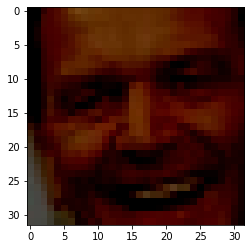

In [76]:
plt.imshow(X[230])
test_person_predict = model.predict(test_person)

In [96]:
names = [f for f in photosDf.Path]
names

[('lfw/George_HW_Bush', 'George_HW_Bush_0001.jpg'),
 ('lfw/George_HW_Bush', 'George_HW_Bush_0003.jpg'),
 ('lfw/George_HW_Bush', 'George_HW_Bush_0004.jpg'),
 ('lfw/George_HW_Bush', 'George_HW_Bush_0005.jpg'),
 ('lfw/George_HW_Bush', 'George_HW_Bush_0006.jpg'),
 ('lfw/George_HW_Bush', 'George_HW_Bush_0007.jpg'),
 ('lfw/George_HW_Bush', 'George_HW_Bush_0008.jpg'),
 ('lfw/George_HW_Bush', 'George_HW_Bush_0009.jpg'),
 ('lfw/George_HW_Bush', 'George_HW_Bush_0010.jpg'),
 ('lfw/George_HW_Bush', 'George_HW_Bush_0011.jpg'),
 ('lfw/George_HW_Bush', 'George_HW_Bush_0012.jpg'),
 ('lfw/George_HW_Bush', 'George_HW_Bush_0013.jpg'),
 ('lfw/Curtis_Strange', 'Curtis_Strange_0001.jpg'),
 ('lfw/Marc_Grossman', 'Marc_Grossman_0001.jpg'),
 ('lfw/Marc_Grossman', 'Marc_Grossman_0002.jpg'),
 ('lfw/Marc_Grossman', 'Marc_Grossman_0003.jpg'),
 ('lfw/Marc_Grossman', 'Marc_Grossman_0004.jpg'),
 ('lfw/Michael_Schumacher', 'Michael_Schumacher_0001.jpg'),
 ('lfw/Michael_Schumacher', 'Michael_Schumacher_0002.jpg'),
 ('l

In [97]:
def recomender(vectors,names,img_path):
    mod = list(vectors)
    s_N = names
    s = pd.Series(s_N)
    s_vector = ([mod])
    df=pd.DataFrame(s)
    df['Vector']=mod
    df.columns=(['name','X'])
    test_person=load_dataset(img_path)
    test_person_pred=encodetor.predict(test_person)
    X_missing=test_person_pred
    df["diffs"] = df["X"].apply(lambda X: np.linalg.norm(X-X_missing))
    results = df.groupby("name").agg({'diffs':'min'}).sort_values(by='diffs')
    return results.index[0]
res = recomender(vectors,names,'../data/elegido')
res

Loaded the images of dataset-Julio

[ 44  25 102 102]
44 25 102 102


('lfw/Mario_Kreutzberger', 'Mario_Kreutzberger_0001.jpg')

In [61]:
train_idx = np.arange(vectors.shape[0]) % 2 != 0
test_idx = np.arange(vectors.shape[0]) % 2 == 0

In [62]:
targets = np.array([f for f in photosDf.File])
targets.shape

(13143,)

In [63]:
encoder = LabelEncoder()
y = encoder.fit_transform(targets)
y


array([3854, 3855, 3856, ..., 7916, 7006, 2416])

In [64]:
X_train.shape

(6571, 1000)

In [65]:
X_train = vectors[train_idx]
X_test = vectors[test_idx]

In [66]:
y_train = y[train_idx]
y_test = y[test_idx]

In [67]:




knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean', n_jobs=6)
svc = LinearSVC()
knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.0, SVM accuracy = 0.0


In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)
neigh.predict

In [ ]:
clf = svm.SVC()
clf.fit(X, y)